In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import netCDF4 as nc
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import string
from geopy.distance import geodesic
import scipy.stats as stats
from scipy.stats import gaussian_kde
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import pearsonr
import matplotlib.colors as colors

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D

In [28]:
def plot_timeseries(df, col, axs, i, j, single_row):
    yearly_mean = df.groupby('year')[col].mean().reset_index()
    years = yearly_mean['year'].values.reshape(-1)
    values = yearly_mean[col].values.reshape(-1)

    if single_row:
        ax = axs[i]
    else:
        ax = axs[i, j]

    sns.regplot(data=yearly_mean, x='year', y=col, ax=ax, scatter=True, ci=95, scatter_kws={'s':25, 'color':'black'}, line_kws={'color':'black', 'linestyle':'--'})    # ci is the confidence interval for regression line, not for individual years
    ax.plot(years, values, linewidth=2, c='black')

    X = sm.add_constant(years)
    model = sm.OLS(values, X).fit()
    slope = model.params[1]
    conf_int = model.conf_int(alpha=0.05)  # alpha=0.05 gives 95% CI
    slope_ci_lower = conf_int[1, 0]  # Lower bound for slope
    slope_ci_upper = conf_int[1, 1]  # Upper bound for slope
    intercept = model.params[0]
    p_value = model.pvalues[1]
    print(f'y = {slope:.2f}x + {intercept:.2f}, p-value = {p_value:.3f}, confidence interval = {slope_ci_lower:.2f} - {slope_ci_upper:.2f}, interval width = {(slope_ci_upper - slope_ci_lower)/2:.2f}')
    
    return years, values

# Fig. 1: duration trend and distribution comparison

In [3]:
def duration_trend_34(basin, duration_type):
    IB_data = pd.read_csv('processed_data/IBTrACS_%s_processed_dt3_202510.csv'%basin)
    IB_data['ISO_TIME'] = pd.to_datetime(IB_data['ISO_TIME'])  # convert to datetime
    ID_unique = sorted(IB_data['USA_ATCF_ID'].unique())        #no missing or blank IDs now

    duration_df = pd.DataFrame(columns=['year', 'ID', 'duration', 'type'])     # duration of TS
    for TC_ID in ID_unique:
        TC_data = IB_data[IB_data['USA_ATCF_ID'] == TC_ID].sort_values(by='ISO_TIME').reset_index(drop=True)
        if len(TC_data) > 0:
            TC_year = TC_data['YEAR'].iloc[0]
            if len(TC_data[TC_data['COMBINE_WIND'] >= 34]) > 0:
                start_idx = TC_data[TC_data['COMBINE_WIND'] >= 34].index[0]
                if len(TC_data[TC_data['NATURE'] == 'TS']) > 0:    
                    end_idx = TC_data[TC_data['NATURE'] == 'TS'].index[-1]
                    if end_idx > start_idx:
                        TC_duration = (TC_data['ISO_TIME'].iloc[end_idx] - TC_data['ISO_TIME'].iloc[start_idx]).total_seconds()/3600 + 3
                        if TC_duration < 100:
                            TC_type = 'short'
                        elif TC_duration < 200:
                            TC_type = 'medium'
                        else:
                            TC_type = 'long'
                        duration_df = pd.concat([duration_df, pd.DataFrame({'year':[TC_year], 'ID':[TC_ID], 'duration':[TC_duration], 'type':[TC_type]})], ignore_index=True)
            
    if duration_type == 'all':
        pass
    else:
        duration_df = duration_df[duration_df['type'] == duration_type]

    return duration_df


In [4]:
def duration_distribution(basin, split_year):
    ibtracs = pd.read_csv('processed_data/IBTrACS_%s_processed_dt3_202510.csv'%basin)
    ibtracs['ISO_TIME'] = pd.to_datetime(ibtracs['ISO_TIME'])
    TC_ID = ibtracs['USA_ATCF_ID'].unique()

    duration_dict = {}
    all_duration = []
    duration_early_epoch = []
    duration_late_epoch = []
    for ID in TC_ID:
        ID_data = ibtracs[ibtracs['USA_ATCF_ID'] == ID].sort_values(by='ISO_TIME').reset_index(drop=True)
        if len(ID_data) > 0:
            ID_year = ID_data['YEAR'].iloc[0]
            if len(ID_data[ID_data['COMBINE_WIND'] >= 34]) > 0:
                start_idx = ID_data[ID_data['COMBINE_WIND'] >= 34].index[0]
                if len(ID_data[ID_data['NATURE'] == 'TS']) > 0:    
                    end_idx = ID_data[ID_data['NATURE'] == 'TS'].index[-1]
                    if end_idx > start_idx:
                        ID_duration = (ID_data['ISO_TIME'].iloc[end_idx] - ID_data['ISO_TIME'].iloc[start_idx]).total_seconds()/3600 + 3
                        if ID_year not in duration_dict:
                            duration_dict[ID_year] = []
                        duration_dict[ID_year].append(ID_duration)
                        all_duration.append(ID_duration)
                        if ID_year <= split_year:
                            duration_early_epoch.append(ID_duration)
                        else:
                            duration_late_epoch.append(ID_duration)
    
    max_duration = max(all_duration)
    min_duration = min(all_duration)
    
    duration_bins = np.linspace(min_duration, max_duration+3, 40)
    max_occurrence_year = []
    for year in duration_dict:
        hist, _ = np.histogram(duration_dict[year], bins=duration_bins)
        max_occurrence_year.append(hist.max())
    max_occurrence_in_bin = max(max_occurrence_year)         
    
    return duration_early_epoch, duration_late_epoch, duration_bins

In [5]:
duration_EP = duration_trend_34('EP', 'all')
duration_WP = duration_trend_34('WP', 'all')

EP_early, EP_late, EP_bins = duration_distribution('EP', 2003)
WP_early, WP_late, WP_bins = duration_distribution('WP', 2003)

y = -1.46x + 3058.52, p-value = 0.000, confidence interval = -2.00 - -0.93, interval width = 0.53
y = -0.71x + 1571.64, p-value = 0.017, confidence interval = -1.29 - -0.14, interval width = 0.58


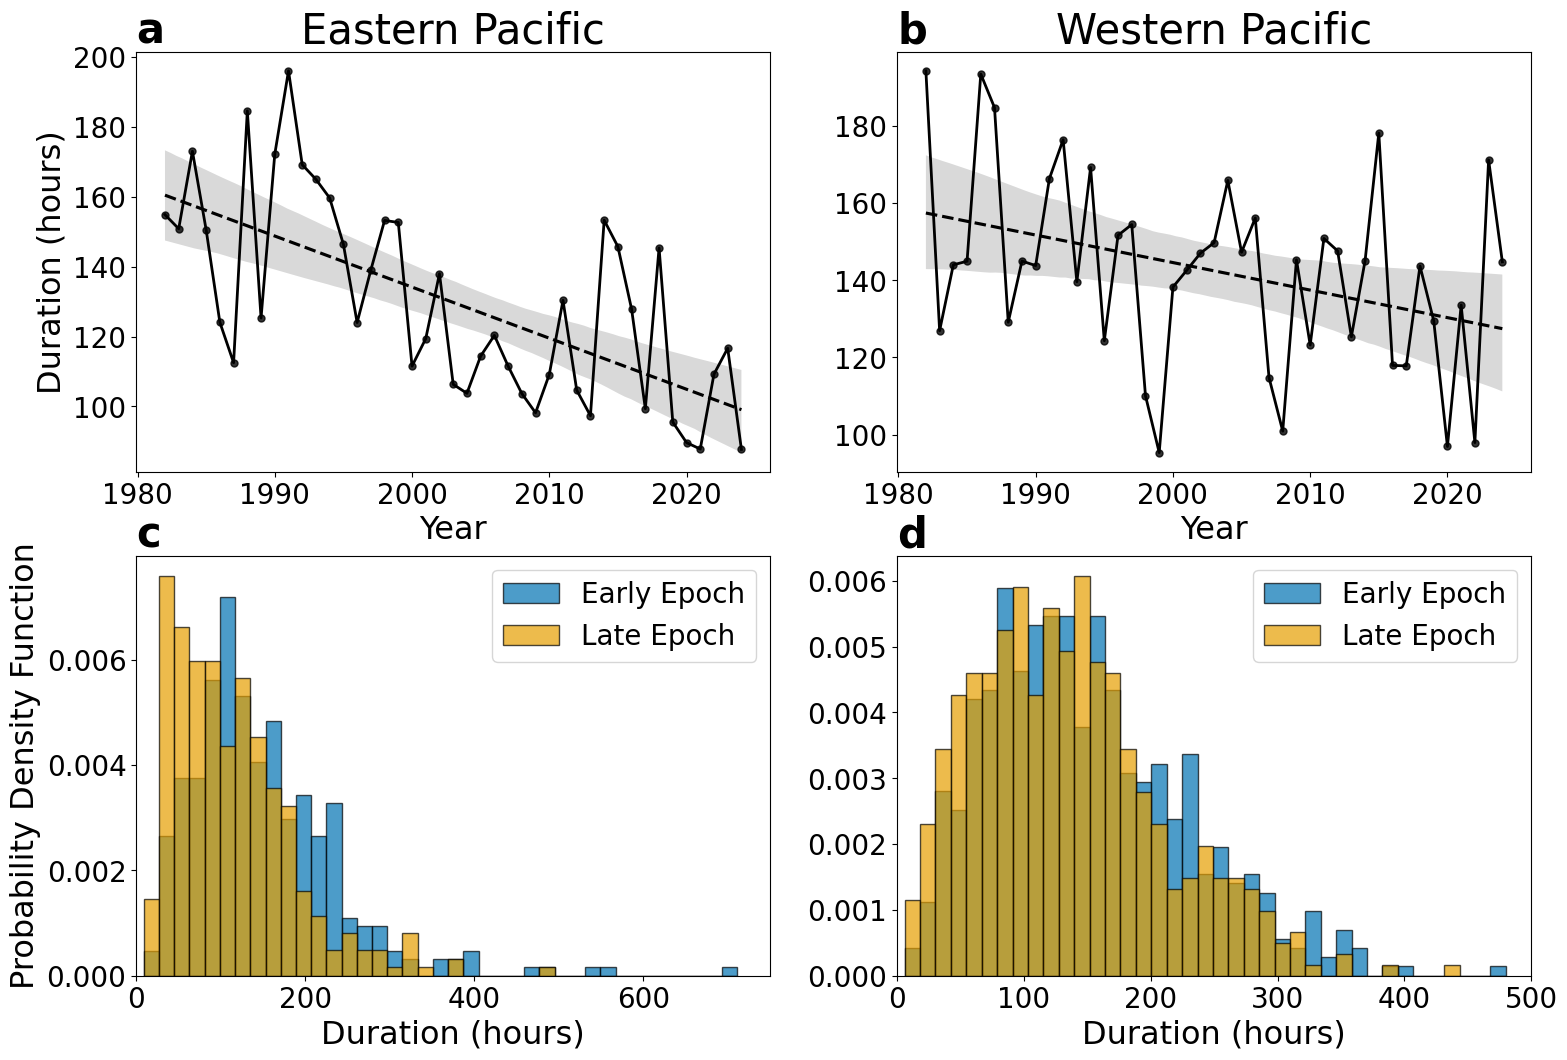

In [29]:
# plot Fig 1

fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Trends
plot_timeseries(duration_EP, 'duration', axs, 0, 0, False)
axs[0, 0].set_title('Eastern Pacific', fontsize=30)
axs[0, 0].set_xlabel('Year', fontsize=23)
axs[0, 0].set_ylabel('Duration (hours)', fontsize=23)
axs[0, 0].tick_params(axis='both', labelsize=20)
axs[0, 0].text(0, 1.02, 'a', transform=axs[0, 0].transAxes, fontsize=30, fontweight='bold')

plot_timeseries(duration_WP, 'duration', axs, 0, 1, False)
axs[0, 1].set_title('Western Pacific', fontsize=30)
axs[0, 1].set_xlabel('Year', fontsize=23)
axs[0, 1].set_ylabel('')
axs[0, 1].tick_params(axis='both', labelsize=20)
axs[0, 1].text(0, 1.02, 'b', transform=axs[0, 1].transAxes, fontsize=30, fontweight='bold')

# Distribution
axs[1, 0].hist(EP_early, bins=EP_bins, density=True, label='Early Epoch', color='#0072B2', edgecolor='black', alpha=0.7)
axs[1, 0].hist(EP_late, bins=EP_bins, density=True, label='Late Epoch', color='#E69F00', edgecolor='black', alpha=0.7)
axs[1, 0].set_xlabel('Duration (hours)', fontsize=23)
axs[1, 0].set_ylabel('Probability Density Function', fontsize=23)
axs[1, 0].legend(fontsize=20)
axs[1, 0].set_xlim([0, 750])
axs[1, 0].tick_params(axis='both', labelsize=20)
axs[1, 0].text(0, 1.02, 'c', transform=axs[1, 0].transAxes, fontsize=30, fontweight='bold')

axs[1, 1].hist(WP_early, bins=WP_bins, density=True, label='Early Epoch', color='#0072B2', edgecolor='black', alpha=0.7)
axs[1, 1].hist(WP_late, bins=WP_bins, density=True, label='Late Epoch', color='#E69F00', edgecolor='black', alpha=0.7)
axs[1, 1].set_xlabel('Duration (hours)', fontsize=23)
axs[1, 1].set_ylabel('')
axs[1, 1].legend(fontsize=20)
axs[1, 1].set_xlim([0, 500])
axs[1, 1].tick_params(axis='both', labelsize=20)
axs[1, 1].text(0, 1.02, 'd', transform=axs[1, 1].transAxes, fontsize=30, fontweight='bold')


plt.subplots_adjust(hspace=0.2)       # adjust space between rows

plt.savefig('figures/duration_trend.png', dpi=300, bbox_inches='tight')
plt.show()
#plt.close()


# Fig. 2: Start latitude trend + Track length trend 

In [7]:
def starting_distance_trend(basin):
    IB_data = pd.read_csv('processed_data/IBTrACS_%s_processed_dt3_202510.csv'%basin)
    IB_data['ISO_TIME'] = pd.to_datetime(IB_data['ISO_TIME'])  # convert to datetime
    ID_unique = sorted(IB_data['USA_ATCF_ID'].unique())        #no missing or blank IDs now

    duration_df = pd.DataFrame(columns=['year', 'ID', 'duration'])     # duration of TS
    for TC_ID in ID_unique:
        TC_data = IB_data[IB_data['USA_ATCF_ID'] == TC_ID].sort_values(by='ISO_TIME').reset_index(drop=True)
        if len(TC_data) > 0:
            TC_year = TC_data['YEAR'].iloc[0]
            if len(TC_data[TC_data['COMBINE_WIND'] >= 34]) > 0:
                start_idx = TC_data[TC_data['COMBINE_WIND'] >= 34].index[0]
                if len(TC_data[TC_data['NATURE'] == 'TS']) > 0:    
                    end_idx = TC_data[TC_data['NATURE'] == 'TS'].index[-1]
                    if end_idx > start_idx:
                        TC_data = TC_data.iloc[start_idx:end_idx+1].reset_index(drop=True)
                        TC_duration = (TC_data['ISO_TIME'].iloc[-1] - TC_data['ISO_TIME'].iloc[0]).total_seconds()/3600 + 3
                        TC_start_distance = TC_data['DIST2LAND'].iloc[0]
                        TC_start_lat = TC_data['LAT'].iloc[0]
                        TC_LMI = TC_data['COMBINE_WIND'].max()
                        track_length = 0
                        
                        for i in range(len(TC_data)-1):
                            point1 = (TC_data.loc[i, 'LAT'], TC_data.loc[i, 'LON'])
                            point2 = (TC_data.loc[i+1, 'LAT'], TC_data.loc[i+1, 'LON'])
                            distance = geodesic(point1, point2).kilometers
                            track_length += distance
                        duration_df = pd.concat([duration_df, pd.DataFrame({'year':[TC_year], 'ID':[TC_ID], 'duration':[TC_duration], 'start_distance':[TC_start_distance], 'LMI':[TC_LMI], 'start_lat':[TC_start_lat], 'track_length':[track_length]})], ignore_index=True)
            
    return duration_df

In [8]:
lat_df_EP = starting_distance_trend('EP')
lat_df_WP = starting_distance_trend('WP')

Start lat EP
y = 0.02x + -35.79, p-value = 0.012, confidence interval = 0.01 - 0.04, interval width = 0.02
Start lat WP
y = 0.06x + -95.36, p-value = 0.009, confidence interval = 0.01 - 0.10, interval width = 0.04
Track length EP
y = -25.08x + 52364.49, p-value = 0.000, confidence interval = -35.44 - -14.72, interval width = 10.36
Track length WP
y = -15.21x + 33184.38, p-value = 0.006, confidence interval = -25.86 - -4.55, interval width = 10.66


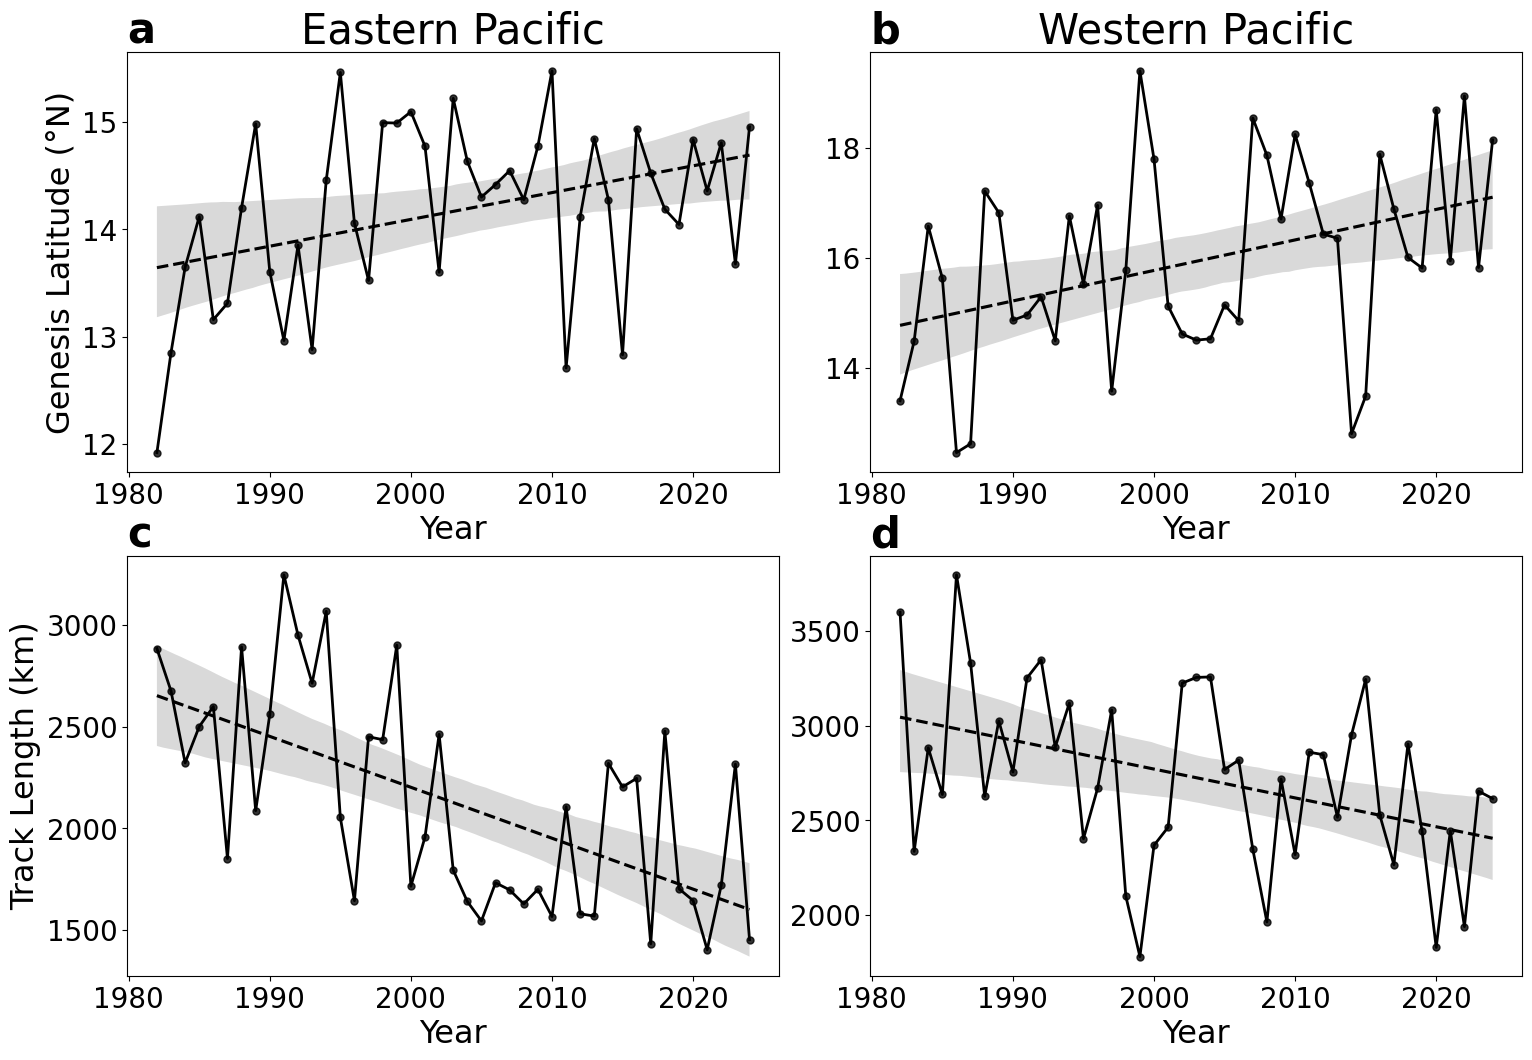

In [30]:
# plot Fig 2

fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Start latitude trend
print('Start lat EP')
plot_timeseries(lat_df_EP, 'start_lat', axs, 0, 0, False)
axs[0, 0].set_title('Eastern Pacific', fontsize=30)
axs[0, 0].set_xlabel('Year', fontsize=23)
axs[0, 0].set_ylabel('Genesis Latitude (°N)', fontsize=23)
axs[0, 0].tick_params(axis='both', labelsize=20)
axs[0, 0].text(0, 1.02, 'a', transform=axs[0, 0].transAxes, fontsize=30, fontweight='bold')

print('Start lat WP')
plot_timeseries(lat_df_WP, 'start_lat', axs, 0, 1, False)
axs[0, 1].set_title('Western Pacific', fontsize=30)
axs[0, 1].set_xlabel('Year', fontsize=23)
axs[0, 1].set_ylabel('')
axs[0, 1].tick_params(axis='both', labelsize=20)
axs[0, 1].text(0, 1.02, 'b', transform=axs[0, 1].transAxes, fontsize=30, fontweight='bold')

# Track length trend
print('Track length EP')
plot_timeseries(lat_df_EP, 'track_length', axs, 1, 0, False)
axs[1, 0].set_xlabel('Year', fontsize=23)
axs[1, 0].set_ylabel('Track Length (km)', fontsize=23)
axs[1, 0].tick_params(axis='both', labelsize=20)
axs[1, 0].text(0, 1.02, 'c', transform=axs[1, 0].transAxes, fontsize=30, fontweight='bold')

print('Track length WP')
plot_timeseries(lat_df_WP, 'track_length', axs, 1, 1, False)
axs[1, 1].set_xlabel('Year', fontsize=23)
axs[1, 1].set_ylabel('')
axs[1, 1].tick_params(axis='both', labelsize=20)
axs[1, 1].text(0, 1.02, 'd', transform=axs[1, 1].transAxes, fontsize=30, fontweight='bold')

plt.subplots_adjust(wspace=0.14)
plt.savefig('figures/migration_trend.png', dpi=300, bbox_inches='tight')
plt.show()

# Fig. 3: Relationship between duration and track length

Eastern Pacific: Pearson r = 0.88, p = 3.81e-225
Western Pacific: Pearson r = 0.83, p = 2.07e-279


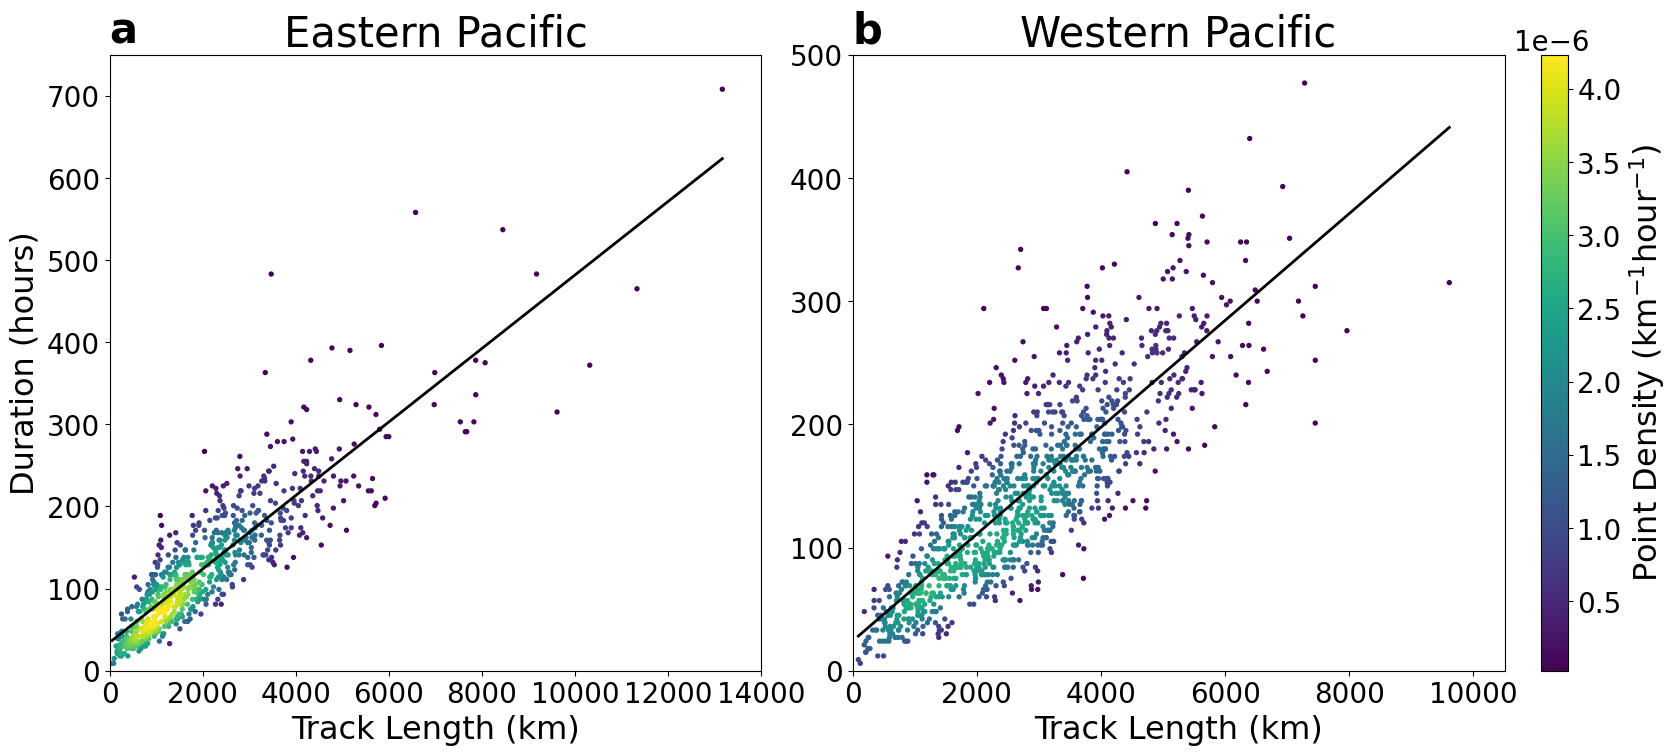

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Calculate densities for both datasets first
xy_EP = np.vstack([lat_df_EP['track_length'], lat_df_EP['duration']])
z_EP = gaussian_kde(xy_EP)(xy_EP)
idx_EP = z_EP.argsort()
x_EP, y_EP, z_EP = lat_df_EP['track_length'].values[idx_EP], lat_df_EP['duration'].values[idx_EP], z_EP[idx_EP]

xy_WP = np.vstack([lat_df_WP['track_length'], lat_df_WP['duration']])
z_WP = gaussian_kde(xy_WP)(xy_WP)
idx_WP = z_WP.argsort()
x_WP, y_WP, z_WP = lat_df_WP['track_length'].values[idx_WP], lat_df_WP['duration'].values[idx_WP], z_WP[idx_WP]

# Unify color scale across both subplots
vmin = min(z_EP.min(), z_WP.min())
vmax = max(z_EP.max(), z_WP.max())

# Plot Eastern Pacific
slope, intercept = np.polyfit(x_EP, y_EP, 1)
line_x = np.array([min(x_EP), max(x_EP)])
line_y = slope * line_x + intercept
from scipy.stats import pearsonr
corr_EP, p_EP = pearsonr(x_EP, y_EP)
print(f'Eastern Pacific: Pearson r = {corr_EP:.2f}, p = {p_EP:.2e}')

axs[0].scatter(x_EP, y_EP, c=z_EP, marker='o', s=8, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].plot(line_x, line_y, 'black', linewidth=2)
axs[0].set_xlabel('Track Length (km)', fontsize=23)
axs[0].set_ylabel('Duration (hours)', fontsize=23)
axs[0].set_title('Eastern Pacific', fontsize=30)
axs[0].set_xlim(0, 14000)
axs[0].set_ylim(0, 750)
axs[0].tick_params(axis='both', labelsize=20)
axs[0].text(0, 1.02, 'a', transform=axs[0].transAxes, fontsize=30, fontweight='bold')

# Plot Western Pacific
slope, intercept = np.polyfit(x_WP, y_WP, 1)
line_x = np.array([min(x_WP), max(x_WP)])
line_y = slope * line_x + intercept
corr_WP, p_WP = pearsonr(x_WP, y_WP)
print(f'Western Pacific: Pearson r = {corr_WP:.2f}, p = {p_WP:.2e}')

axs[1].scatter(x_WP, y_WP, c=z_WP, marker='o', s=8, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].plot(line_x, line_y, 'black', linewidth=2)
axs[1].set_xlabel('Track Length (km)', fontsize=23)
axs[1].set_ylabel('')
axs[1].set_title('Western Pacific', fontsize=30)
axs[1].set_xlim(0, 10500)
axs[1].set_ylim(0, 500)
axs[1].tick_params(axis='both', labelsize=20)
axs[1].text(0, 1.02, 'b', transform=axs[1].transAxes, fontsize=30, fontweight='bold')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.11, 0.015, 0.77])
cbar = fig.colorbar(axs[0].collections[0], cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Point Density (km$^{-1}$hour$^{-1}$)', fontsize=23)
offset_text = cbar.ax.yaxis.get_offset_text()      # 1e-6
offset_text.set_fontsize(20)  # Increase font size of scientific notation (1e-6)
offset_text.set_x(1.8)  # Move it to the right by changing alignment

plt.subplots_adjust(wspace=0.14)
plt.savefig('figures/relation_duration_track.png', dpi=300, bbox_inches='tight')
plt.show()

# Fig. 4: Duration and DELV trends before/after LMI

In [11]:
# plot TC DELV trends

def plot_DELV_trend(basin, dt, only_6):
    IB_data = pd.read_csv('processed_data/IBTrACS_%s_processed_dt3_202510.csv'%(basin))
    IB_data['ISO_TIME'] = pd.to_datetime(IB_data['ISO_TIME'])
    if only_6:
        IB_data = IB_data[IB_data['ISO_TIME'].dt.hour.isin([0, 6, 12, 18])]

    TC_DELV_df = pd.DataFrame(columns=['YEAR', 'USA_ATCF_ID', 'DELV', 'abs_DELV'])
    TC_before_DELV_df = pd.DataFrame(columns=['YEAR', 'USA_ATCF_ID', 'DELV'])
    TC_after_DELV_df = pd.DataFrame(columns=['YEAR', 'USA_ATCF_ID', 'DELV'])
    TC_duration_before_df = pd.DataFrame(columns=['YEAR', 'USA_ATCF_ID', 'duration'])
    TC_duration_after_df = pd.DataFrame(columns=['YEAR', 'USA_ATCF_ID', 'duration'])

    ID_unique = sorted(IB_data['USA_ATCF_ID'].unique())

    for TC_ID in ID_unique:
        TC_ID_data = IB_data[IB_data['USA_ATCF_ID'] == TC_ID].sort_values(by='ISO_TIME').reset_index(drop=True)
        if len(TC_ID_data) > 0:
            TC_year = TC_ID_data['YEAR'].iloc[0]
            if len(TC_ID_data[TC_ID_data['COMBINE_WIND'] >= 34]) > 0:
                start_idx = TC_ID_data[TC_ID_data['COMBINE_WIND'] >= 34].index[0]
                if len(TC_ID_data[TC_ID_data['NATURE'] == 'TS']) > 0:    
                    end_idx = TC_ID_data[TC_ID_data['NATURE'] == 'TS'].index[-1]
                    if end_idx > start_idx:
                        TC_ID_data = TC_ID_data.iloc[start_idx:end_idx+1].reset_index(drop=True)
                        before_len = len(TC_ID_data)
                        TC_ID_data = TC_ID_data.dropna(subset=['COMBINE_WIND']).reset_index(drop=True)
                        after_len = len(TC_ID_data)
                        if len(TC_ID_data) > 0:
                            LMI_idx = TC_ID_data['COMBINE_WIND'].idxmax()
                            LMI_time = TC_ID_data['ISO_TIME'].iloc[LMI_idx]
                            before_stop_time = LMI_time - pd.Timedelta(hours=dt)

                            TC_ID_DT = TC_ID_data[['ISO_TIME', 'COMBINE_WIND']]
                            TC_ID_DT['ISO_TIME'] = TC_ID_DT['ISO_TIME'] - pd.Timedelta(hours=dt)
                            TC_ID_DT.rename(columns={'COMBINE_WIND':'COMBINE_WIND_DT'}, inplace=True)
                            TC_ID_DELV = pd.merge(TC_ID_data, TC_ID_DT, on='ISO_TIME', how='inner')
                            TC_ID_DELV['DELV'] = TC_ID_DELV['COMBINE_WIND_DT'] - TC_ID_DELV['COMBINE_WIND']
                            TC_ID_DELV['abs_DELV'] = np.abs(TC_ID_DELV['DELV'])
                            TC_ID_DELV.reset_index(drop=True, inplace=True)
                            TC_ID_before = TC_ID_DELV[TC_ID_DELV['ISO_TIME'] <= before_stop_time]
                            TC_ID_after = TC_ID_DELV[TC_ID_DELV['ISO_TIME'] >= LMI_time]

                            TC_DELV_df = pd.concat([TC_DELV_df, TC_ID_DELV[['YEAR', 'USA_ATCF_ID', 'DELV', 'abs_DELV']]], ignore_index=True)
                            TC_before_DELV_df = pd.concat([TC_before_DELV_df, TC_ID_before[['YEAR', 'USA_ATCF_ID', 'DELV']]], ignore_index=True)
                            TC_after_DELV_df = pd.concat([TC_after_DELV_df, TC_ID_after[['YEAR', 'USA_ATCF_ID', 'DELV']]], ignore_index=True)

    TC_DELV_df.rename(columns={'YEAR':'year'}, inplace=True)      
    TC_before_DELV_df.rename(columns={'YEAR':'year'}, inplace=True)
    TC_after_DELV_df.rename(columns={'YEAR':'year'}, inplace=True)
    TC_DELV_df['year'] = TC_DELV_df['year'].astype(int)
    TC_before_DELV_df['year'] = TC_before_DELV_df['year'].astype(int)
    TC_after_DELV_df['year'] = TC_after_DELV_df['year'].astype(int)
    return TC_DELV_df, TC_before_DELV_df, TC_after_DELV_df

In [12]:
DELV_EP_all, DELV_EP_before, DELV_EP_after = plot_DELV_trend('EP', 6, False)
DELV_WP_all, DELV_WP_before, DELV_WP_after = plot_DELV_trend('WP', 6, False)

DELV_EP_before_yearly = DELV_EP_before.groupby('year')['DELV'].mean().reset_index()
DELV_EP_after_yearly = DELV_EP_after.groupby('year')['DELV'].mean().reset_index()
DELV_WP_before_yearly = DELV_WP_before.groupby('year')['DELV'].mean().reset_index()
DELV_WP_after_yearly = DELV_WP_after.groupby('year')['DELV'].mean().reset_index()

DELV_EP_after_yearly['DELV'] = DELV_EP_after_yearly['DELV'] * (-1)     # convert to abs(DELV), only required for after LMI because before LMI is positive
DELV_WP_after_yearly['DELV'] = DELV_WP_after_yearly['DELV'] * (-1)     


In [13]:
# duration

properties_EP = pd.read_csv('data/properties/properties_EP_202510.csv')
properties_WP = pd.read_csv('data/properties/properties_WP_202510.csv')

properties_EP_yearly = properties_EP.groupby('year')[['duration_before_LMI', 'intensity_range_1', 'duration_after_LMI', 'intensity_range_2']].mean().reset_index()
properties_WP_yearly = properties_WP.groupby('year')[['duration_before_LMI', 'intensity_range_1', 'duration_after_LMI', 'intensity_range_2']].mean().reset_index()

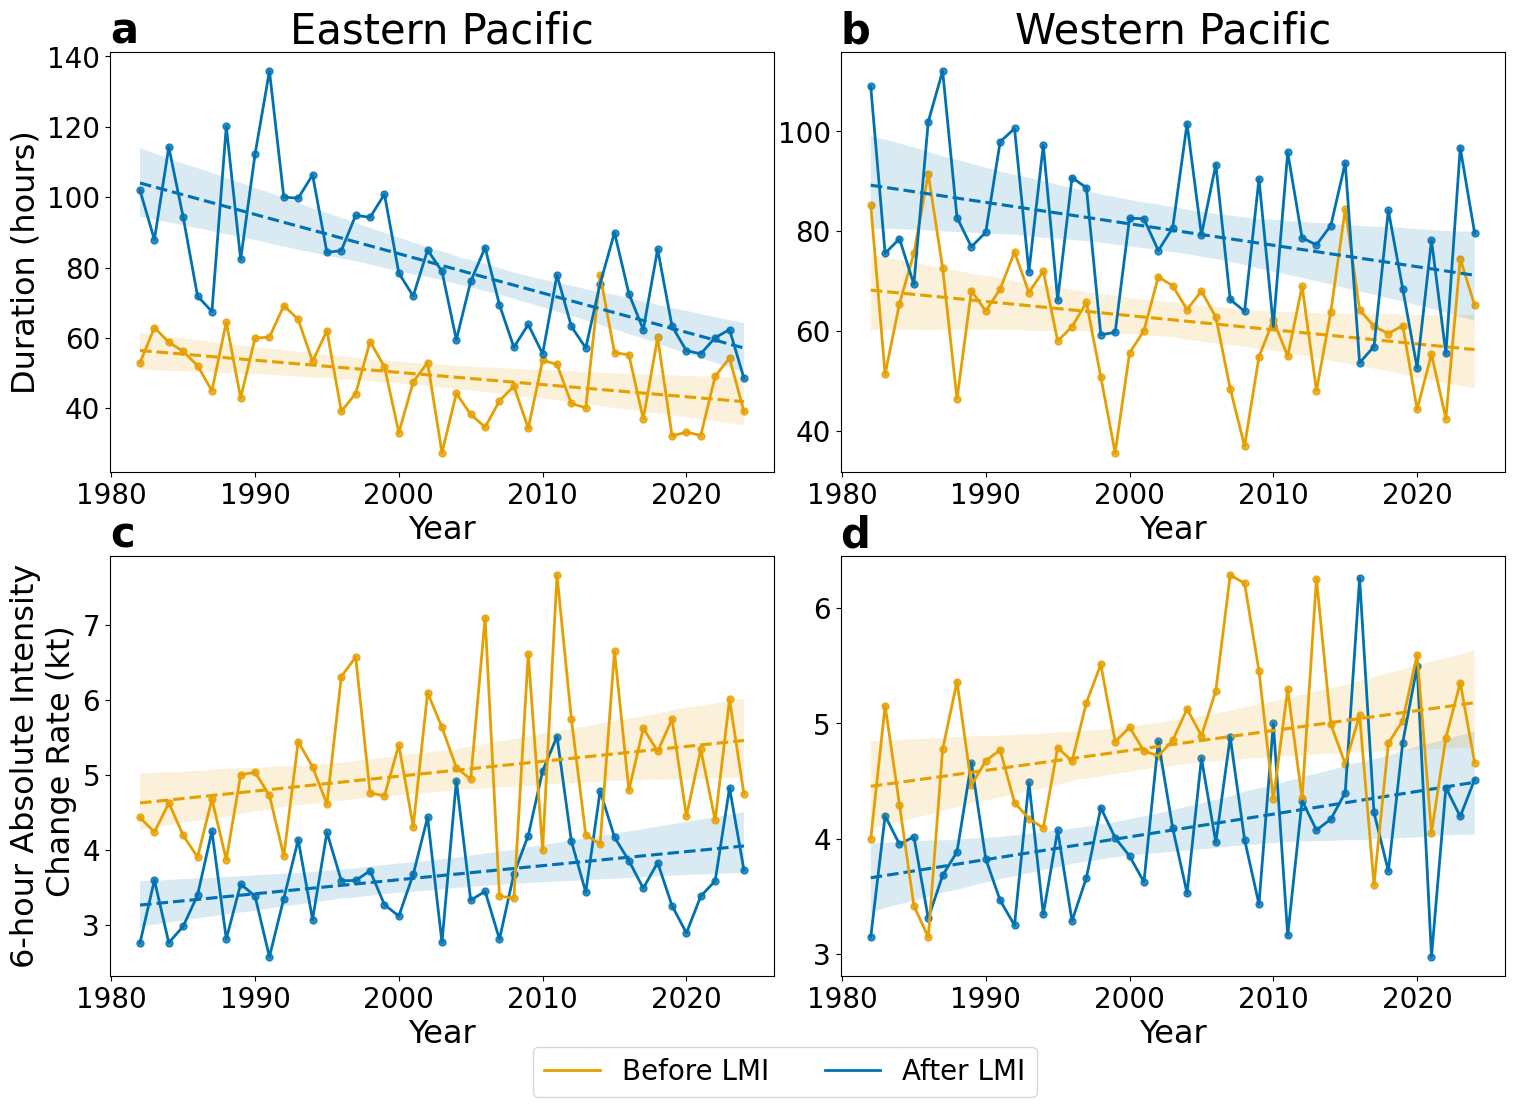

EP Duration Before LMI: y = -0.346x + 742.281, p = 0.013, CI = (-0.616, -0.076), CI width = 0.270
EP Duration After LMI: y = -1.116x + 2316.240, p = 0.000, CI = (-1.474, -0.758), CI width = 0.358
WP Duration Before LMI: y = -0.284x + 630.466, p = 0.055, CI = (-0.574, 0.006), CI width = 0.290
WP Duration After LMI: y = -0.430x + 941.171, p = 0.021, CI = (-0.790, -0.069), CI width = 0.361
EP DELV Before LMI: y = 0.020x + -34.617, p = 0.101, CI = (-0.004, 0.044), CI width = 0.024
EP DELV After LMI: y = 0.019x + -33.846, p = 0.023, CI = (0.003, 0.035), CI width = 0.016
WP DELV Before LMI: y = 0.017x + -29.792, p = 0.034, CI = (0.001, 0.033), CI width = 0.016
WP DELV After LMI: y = 0.020x + -35.436, p = 0.013, CI = (0.004, 0.035), CI width = 0.015
EP intensity range 1: y = -0.113x + 266.568, p = 0.373, CI = (-0.367, 0.140), CI width = 0.254
EP intensity range 2: y = -0.359x + 766.614, p = 0.005, CI = (-0.603, -0.115), CI width = 0.244
WP intensity range 1: y = -0.012x + 71.992, p = 0.900, C

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Duration
sns.regplot(x='year', y='duration_before_LMI', data=properties_EP_yearly, ax=axs[0, 0], scatter=True, ci=95, scatter_kws={'s':25, 'color':'#E69F00'}, line_kws={'color': '#E69F00', 'linestyle': '--'})
axs[0, 0].plot(properties_EP_yearly['year'].values.reshape(-1), properties_EP_yearly['duration_before_LMI'].values.reshape(-1), '#E69F00', linewidth=2)
sns.regplot(x='year', y='duration_after_LMI', data=properties_EP_yearly, ax=axs[0, 0], scatter=True, ci=95, scatter_kws={'s':25, 'color':'#0072B2'}, line_kws={'color': '#0072B2', 'linestyle': '--'})
axs[0, 0].plot(properties_EP_yearly['year'].values.reshape(-1), properties_EP_yearly['duration_after_LMI'].values.reshape(-1), '#0072B2', linewidth=2)
axs[0, 0].set_title('Eastern Pacific', fontsize=30)
axs[0, 0].set_xlabel('Year', fontsize=23)
axs[0, 0].set_ylabel('Duration (hours)', fontsize=23)
axs[0, 0].tick_params(axis='both', labelsize=20)
axs[0, 0].text(0, 1.02, 'a', transform=axs[0, 0].transAxes, fontsize=30, fontweight='bold')

sns.regplot(x='year', y='duration_before_LMI', data=properties_WP_yearly, ax=axs[0, 1], scatter=True, ci=95, scatter_kws={'s':25, 'color':'#E69F00'}, line_kws={'color': '#E69F00', 'linestyle': '--'})
axs[0, 1].plot(properties_WP_yearly['year'].values.reshape(-1), properties_WP_yearly['duration_before_LMI'].values.reshape(-1), '#E69F00', linewidth=2)
sns.regplot(x='year', y='duration_after_LMI', data=properties_WP_yearly, ax=axs[0, 1], scatter=True, ci=95, scatter_kws={'s':25, 'color':'#0072B2'}, line_kws={'color': '#0072B2', 'linestyle': '--'})
axs[0, 1].plot(properties_WP_yearly['year'].values.reshape(-1), properties_WP_yearly['duration_after_LMI'].values.reshape(-1), '#0072B2', linewidth=2)
axs[0, 1].set_title('Western Pacific', fontsize=30)
axs[0, 1].set_xlabel('Year', fontsize=23)
axs[0, 1].set_ylabel('')
axs[0, 1].tick_params(axis='both', labelsize=20)
axs[0, 1].text(0, 1.02, 'b', transform=axs[0, 1].transAxes, fontsize=30, fontweight='bold')


# absolute DELV
sns.regplot(x='year', y='DELV', data=DELV_EP_after_yearly, ax=axs[1, 0], scatter=True, ci=95, scatter_kws={'s':25, 'color':'#0072B2'}, line_kws={'color': '#0072B2', 'linestyle': '--'})
axs[1, 0].plot(DELV_EP_after_yearly['year'].values.reshape(-1), DELV_EP_after_yearly['DELV'].values.reshape(-1), '#0072B2', linewidth=2)
sns.regplot(x='year', y='DELV', data=DELV_EP_before_yearly, ax=axs[1, 0], scatter=True, ci=95, scatter_kws={'s':25, 'color':'#E69F00'}, line_kws={'color': '#E69F00', 'linestyle': '--'})
axs[1, 0].plot(DELV_EP_before_yearly['year'].values.reshape(-1), DELV_EP_before_yearly['DELV'].values.reshape(-1), '#E69F00', linewidth=2)
axs[1, 0].set_xlabel('Year', fontsize=23)
axs[1, 0].set_ylabel('6-hour Absolute Intensity\n Change Rate (kt)', fontsize=23)
axs[1, 0].tick_params(axis='both', labelsize=20)
axs[1, 0].text(0, 1.02, 'c', transform=axs[1, 0].transAxes, fontsize=30, fontweight='bold')

sns.regplot(x='year', y='DELV', data=DELV_WP_after_yearly, ax=axs[1, 1], scatter=True, ci=95, scatter_kws={'s':25, 'color':'#0072B2'}, line_kws={'color': '#0072B2', 'linestyle': '--'})
axs[1, 1].plot(DELV_WP_after_yearly['year'].values.reshape(-1), DELV_WP_after_yearly['DELV'].values.reshape(-1), '#0072B2', linewidth=2)
sns.regplot(x='year', y='DELV', data=DELV_WP_before_yearly, ax=axs[1, 1], scatter=True, ci=95, scatter_kws={'s':25, 'color':'#E69F00'}, line_kws={'color': '#E69F00', 'linestyle': '--'})
axs[1, 1].plot(DELV_WP_before_yearly['year'].values.reshape(-1), DELV_WP_before_yearly['DELV'].values.reshape(-1), '#E69F00', linewidth=2)
axs[1, 1].set_xlabel('Year', fontsize=23)
axs[1, 1].set_ylabel('')
axs[1, 1].tick_params(axis='both', labelsize=20)
axs[1, 1].text(0, 1.02, 'd', transform=axs[1, 1].transAxes, fontsize=30, fontweight='bold')

# Add legend at bottom of figure
legend_elements = [Line2D([0], [0], color='#E69F00', label='Before LMI', linewidth=2), Line2D([0], [0], color='#0072B2', label='After LMI', linewidth=2)]
fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.03), ncol=2, fontsize=20)

plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/DELV_trend.png', dpi=300, bbox_inches='tight')
plt.show()



# EP before LMI duration
X = sm.add_constant(properties_EP_yearly['year'])
model_EP_before = sm.OLS(properties_EP_yearly['duration_before_LMI'], X).fit()
slope_EP_before = model_EP_before.params[1]
intercept_EP_before = model_EP_before.params[0]
p_value_EP_before = model_EP_before.pvalues[1]
ci_EP_before = model_EP_before.conf_int().iloc[1]

# EP after LMI duration  
model_EP_after = sm.OLS(properties_EP_yearly['duration_after_LMI'], X).fit()
slope_EP_after = model_EP_after.params[1]
intercept_EP_after = model_EP_after.params[0]
p_value_EP_after = model_EP_after.pvalues[1]
ci_EP_after = model_EP_after.conf_int().iloc[1]

# WP before LMI duration
X = sm.add_constant(properties_WP_yearly['year'])
model_WP_before = sm.OLS(properties_WP_yearly['duration_before_LMI'], X).fit()
slope_WP_before = model_WP_before.params[1]
intercept_WP_before = model_WP_before.params[0]
p_value_WP_before = model_WP_before.pvalues[1]
ci_WP_before = model_WP_before.conf_int().iloc[1]

# WP after LMI duration
model_WP_after = sm.OLS(properties_WP_yearly['duration_after_LMI'], X).fit()
slope_WP_after = model_WP_after.params[1]
intercept_WP_after = model_WP_after.params[0]
p_value_WP_after = model_WP_after.pvalues[1]
ci_WP_after = model_WP_after.conf_int().iloc[1]

# EP before LMI DELV
X = sm.add_constant(DELV_EP_before_yearly['year'])
model_EP_before_DELV = sm.OLS(DELV_EP_before_yearly['DELV'], X).fit()
slope_EP_before_DELV = model_EP_before_DELV.params[1]
intercept_EP_before_DELV = model_EP_before_DELV.params[0]
p_value_EP_before_DELV = model_EP_before_DELV.pvalues[1]
ci_EP_before_DELV = model_EP_before_DELV.conf_int().iloc[1]

# EP after LMI DELV
model_EP_after_DELV = sm.OLS(DELV_EP_after_yearly['DELV'], X).fit()
slope_EP_after_DELV = model_EP_after_DELV.params[1]
intercept_EP_after_DELV = model_EP_after_DELV.params[0]
p_value_EP_after_DELV = model_EP_after_DELV.pvalues[1]
ci_EP_after_DELV = model_EP_after_DELV.conf_int().iloc[1]

# WP before LMI DELV
X = sm.add_constant(DELV_WP_before_yearly['year'])
model_WP_before_DELV = sm.OLS(DELV_WP_before_yearly['DELV'], X).fit()
slope_WP_before_DELV = model_WP_before_DELV.params[1]
intercept_WP_before_DELV = model_WP_before_DELV.params[0]
p_value_WP_before_DELV = model_WP_before_DELV.pvalues[1]
ci_WP_before_DELV = model_WP_before_DELV.conf_int().iloc[1]

# WP after LMI DELV
model_WP_after_DELV = sm.OLS(DELV_WP_after_yearly['DELV'], X).fit()
slope_WP_after_DELV = model_WP_after_DELV.params[1]
intercept_WP_after_DELV = model_WP_after_DELV.params[0]
p_value_WP_after_DELV = model_WP_after_DELV.pvalues[1]
ci_WP_after_DELV = model_WP_after_DELV.conf_int().iloc[1]

# EP intensity range 1
X = sm.add_constant(properties_EP_yearly['year'])
model_EP_intensity_range_1 = sm.OLS(properties_EP_yearly['intensity_range_1'], X).fit()
slope_EP_intensity_range_1 = model_EP_intensity_range_1.params[1]
intercept_EP_intensity_range_1 = model_EP_intensity_range_1.params[0]
p_value_EP_intensity_range_1 = model_EP_intensity_range_1.pvalues[1]
ci_EP_intensity_range_1 = model_EP_intensity_range_1.conf_int().iloc[1]

# EP intensity range 2
X = sm.add_constant(properties_EP_yearly['year'])
model_EP_intensity_range_2 = sm.OLS(properties_EP_yearly['intensity_range_2'], X).fit()
slope_EP_intensity_range_2 = model_EP_intensity_range_2.params[1]
intercept_EP_intensity_range_2 = model_EP_intensity_range_2.params[0]
p_value_EP_intensity_range_2 = model_EP_intensity_range_2.pvalues[1]
ci_EP_intensity_range_2 = model_EP_intensity_range_2.conf_int().iloc[1]

# WP intensity range 1
X = sm.add_constant(properties_WP_yearly['year'])
model_WP_intensity_range_1 = sm.OLS(properties_WP_yearly['intensity_range_1'], X).fit()
slope_WP_intensity_range_1 = model_WP_intensity_range_1.params[1]
intercept_WP_intensity_range_1 = model_WP_intensity_range_1.params[0]
p_value_WP_intensity_range_1 = model_WP_intensity_range_1.pvalues[1]
ci_WP_intensity_range_1 = model_WP_intensity_range_1.conf_int().iloc[1]

# WP intensity range 2
X = sm.add_constant(properties_WP_yearly['year'])
model_WP_intensity_range_2 = sm.OLS(properties_WP_yearly['intensity_range_2'], X).fit()
slope_WP_intensity_range_2 = model_WP_intensity_range_2.params[1]
intercept_WP_intensity_range_2 = model_WP_intensity_range_2.params[0]
p_value_WP_intensity_range_2 = model_WP_intensity_range_2.pvalues[1]
ci_WP_intensity_range_2 = model_WP_intensity_range_2.conf_int().iloc[1]



print(f'EP Duration Before LMI: y = {slope_EP_before:.3f}x + {intercept_EP_before:.3f}, p = {p_value_EP_before:.3f}, CI = ({ci_EP_before[0]:.3f}, {ci_EP_before[1]:.3f}), CI width = {(ci_EP_before[1] - ci_EP_before[0])/2:.3f}')
print(f'EP Duration After LMI: y = {slope_EP_after:.3f}x + {intercept_EP_after:.3f}, p = {p_value_EP_after:.3f}, CI = ({ci_EP_after[0]:.3f}, {ci_EP_after[1]:.3f}), CI width = {(ci_EP_after[1] - ci_EP_after[0])/2:.3f}')
print(f'WP Duration Before LMI: y = {slope_WP_before:.3f}x + {intercept_WP_before:.3f}, p = {p_value_WP_before:.3f}, CI = ({ci_WP_before[0]:.3f}, {ci_WP_before[1]:.3f}), CI width = {(ci_WP_before[1] - ci_WP_before[0])/2:.3f}')
print(f'WP Duration After LMI: y = {slope_WP_after:.3f}x + {intercept_WP_after:.3f}, p = {p_value_WP_after:.3f}, CI = ({ci_WP_after[0]:.3f}, {ci_WP_after[1]:.3f}), CI width = {(ci_WP_after[1] - ci_WP_after[0])/2:.3f}')
print(f'EP DELV Before LMI: y = {slope_EP_before_DELV:.3f}x + {intercept_EP_before_DELV:.3f}, p = {p_value_EP_before_DELV:.3f}, CI = ({ci_EP_before_DELV[0]:.3f}, {ci_EP_before_DELV[1]:.3f}), CI width = {(ci_EP_before_DELV[1] - ci_EP_before_DELV[0])/2:.3f}')
print(f'EP DELV After LMI: y = {slope_EP_after_DELV:.3f}x + {intercept_EP_after_DELV:.3f}, p = {p_value_EP_after_DELV:.3f}, CI = ({ci_EP_after_DELV[0]:.3f}, {ci_EP_after_DELV[1]:.3f}), CI width = {(ci_EP_after_DELV[1] - ci_EP_after_DELV[0])/2:.3f}')
print(f'WP DELV Before LMI: y = {slope_WP_before_DELV:.3f}x + {intercept_WP_before_DELV:.3f}, p = {p_value_WP_before_DELV:.3f}, CI = ({ci_WP_before_DELV[0]:.3f}, {ci_WP_before_DELV[1]:.3f}), CI width = {(ci_WP_before_DELV[1] - ci_WP_before_DELV[0])/2:.3f}')
print(f'WP DELV After LMI: y = {slope_WP_after_DELV:.3f}x + {intercept_WP_after_DELV:.3f}, p = {p_value_WP_after_DELV:.3f}, CI = ({ci_WP_after_DELV[0]:.3f}, {ci_WP_after_DELV[1]:.3f}), CI width = {(ci_WP_after_DELV[1] - ci_WP_after_DELV[0])/2:.3f}')
print(f'EP intensity range 1: y = {slope_EP_intensity_range_1:.3f}x + {intercept_EP_intensity_range_1:.3f}, p = {p_value_EP_intensity_range_1:.3f}, CI = ({ci_EP_intensity_range_1[0]:.3f}, {ci_EP_intensity_range_1[1]:.3f}), CI width = {(ci_EP_intensity_range_1[1] - ci_EP_intensity_range_1[0])/2:.3f}')
print(f'EP intensity range 2: y = {slope_EP_intensity_range_2:.3f}x + {intercept_EP_intensity_range_2:.3f}, p = {p_value_EP_intensity_range_2:.3f}, CI = ({ci_EP_intensity_range_2[0]:.3f}, {ci_EP_intensity_range_2[1]:.3f}), CI width = {(ci_EP_intensity_range_2[1] - ci_EP_intensity_range_2[0])/2:.3f}')
print(f'WP intensity range 1: y = {slope_WP_intensity_range_1:.3f}x + {intercept_WP_intensity_range_1:.3f}, p = {p_value_WP_intensity_range_1:.3f}, CI = ({ci_WP_intensity_range_1[0]:.3f}, {ci_WP_intensity_range_1[1]:.3f}), CI width = {(ci_WP_intensity_range_1[1] - ci_WP_intensity_range_1[0])/2:.3f}')
print(f'WP intensity range 2: y = {slope_WP_intensity_range_2:.3f}x + {intercept_WP_intensity_range_2:.3f}, p = {p_value_WP_intensity_range_2:.3f}, CI = ({ci_WP_intensity_range_2[0]:.3f}, {ci_WP_intensity_range_2[1]:.3f}), CI width = {(ci_WP_intensity_range_2[1] - ci_WP_intensity_range_2[0])/2:.3f}')


# Fig. S1: duration distribution group compare

In [15]:
def plot_duration_distribution_3bins(basin):
    ibtracs = pd.read_csv('processed_data/IBTrACS_%s_processed_dt3_202510.csv'%basin)
    ibtracs['ISO_TIME'] = pd.to_datetime(ibtracs['ISO_TIME'])
    ID_unique = sorted(ibtracs['USA_ATCF_ID'].unique())
    duration_dict = {}

    for TC_ID in ID_unique:
        TC_data = ibtracs[ibtracs['USA_ATCF_ID'] == TC_ID].sort_values(by='ISO_TIME').reset_index(drop=True)
        if len(TC_data) > 0:
            TC_year = TC_data['YEAR'].iloc[0]
            if len(TC_data[TC_data['COMBINE_WIND'] >= 34]) > 0:
                start_idx = TC_data[TC_data['COMBINE_WIND'] >= 34].index[0]
                if len(TC_data[TC_data['NATURE'] == 'TS']) > 0:    
                    end_idx = TC_data[TC_data['NATURE'] == 'TS'].index[-1]
                    if end_idx > start_idx:
                        TC_duration = (TC_data['ISO_TIME'].iloc[end_idx] - TC_data['ISO_TIME'].iloc[start_idx]).total_seconds()/3600 + 3
                        if TC_year not in duration_dict:
                            duration_dict[TC_year] = []
                        duration_dict[TC_year].append(TC_duration)

    years = ibtracs['YEAR'].unique()
    duration_ranges = [(0, 100), (100, 200), (200, np.inf)]

    df_timeseries = pd.DataFrame(columns=['year', 'Mean_All'] + [f'Count_{idx}' for idx in np.arange(1,4)], dtype=float)
    for year in years:
        annual_mean_all = np.mean(duration_dict[year])
        
        bin_counts = []
        for start, end in duration_ranges:
            bin_durations = [d for d in duration_dict[year] if start <= d < end]
            bin_count = len(bin_durations)
            bin_counts.append(bin_count)
            
        new_row = pd.DataFrame([[year, annual_mean_all] + bin_counts], columns=['year', 'Mean_All'] + [f'Count_{idx}' for idx in np.arange(1,4)])
        df_timeseries = pd.concat([df_timeseries, new_row], ignore_index=True)
    
    correlations = []
    p_values = []
    for idx in range(1,4):
        corr, p_val = pearsonr(df_timeseries['Mean_All'], df_timeseries[f'Count_{idx}'])
        correlations.append(corr)
        p_values.append(p_val)

    print(f"\n{basin} Basin Correlations:")
    for idx, (corr, p_val) in enumerate(zip(correlations, p_values)):
        duration_range = duration_ranges[idx]
        print(f"Duration {duration_range[0]}-{duration_range[1]}h: r = {corr:.3f}, p = {p_val:.3e}")

    
    return df_timeseries


df_EP = plot_duration_distribution_3bins('EP')
df_WP = plot_duration_distribution_3bins('WP')





EP Basin Correlations:
Duration 0-100h: r = -0.674, p = 7.250e-07
Duration 100-200h: r = 0.252, p = 1.037e-01
Duration 200-infh: r = 0.800, p = 1.184e-10

WP Basin Correlations:
Duration 0-100h: r = -0.730, p = 2.848e-08
Duration 100-200h: r = 0.121, p = 4.387e-01
Duration 200-infh: r = 0.863, p = 1.050e-13


y = 0.12x + -225.44, p-value = 0.001, confidence interval = 0.05 - 0.18, interval width = 0.06
y = -0.05x + 100.54, p-value = 0.156, confidence interval = -0.11 - 0.02, interval width = 0.07
y = -0.08x + 168.41, p-value = 0.001, confidence interval = -0.13 - -0.03, interval width = 0.05
y = 0.06x + -109.08, p-value = 0.148, confidence interval = -0.02 - 0.14, interval width = 0.08
y = -0.05x + 110.51, p-value = 0.238, confidence interval = -0.13 - 0.03, interval width = 0.08
y = -0.12x + 243.17, p-value = 0.004, confidence interval = -0.20 - -0.04, interval width = 0.08


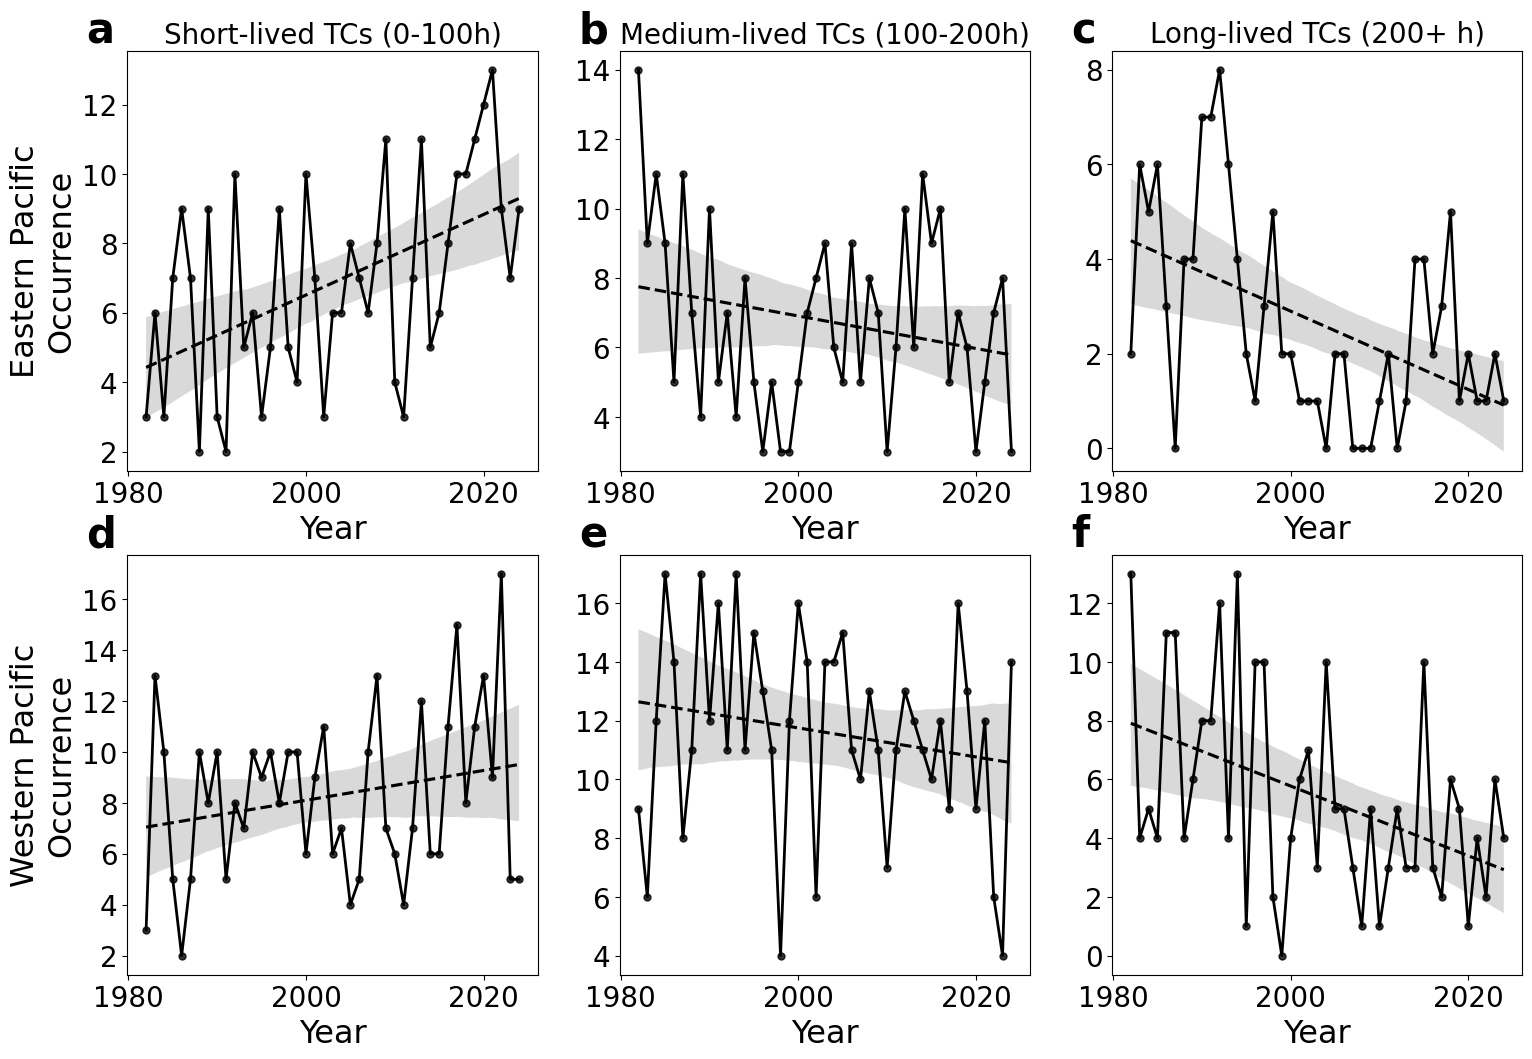

In [32]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

plot_timeseries(df_EP, 'Count_1', axs, 0, 0, False)
axs[0, 0].set_title('Short-lived TCs (0-100h)', fontsize=20)
axs[0, 0].set_xlabel('Year', fontsize=23)
axs[0, 0].set_ylabel('Eastern Pacific\nOccurrence', fontsize=23)
axs[0, 0].tick_params(axis='both', labelsize=20)
axs[0, 0].text(-0.1, 1.02, 'a', transform=axs[0, 0].transAxes, fontsize=30, fontweight='bold')

plot_timeseries(df_EP, 'Count_2', axs, 0, 1, False)
axs[0, 1].set_title('Medium-lived TCs (100-200h)', fontsize=20)
axs[0, 1].set_xlabel('Year', fontsize=23)
axs[0, 1].set_ylabel('')
axs[0, 1].tick_params(axis='both', labelsize=20)
axs[0, 1].text(-0.1, 1.02, 'b', transform=axs[0, 1].transAxes, fontsize=30, fontweight='bold')

plot_timeseries(df_EP, 'Count_3', axs, 0, 2, False)
axs[0, 2].set_title('Long-lived TCs (200+ h)', fontsize=20)
axs[0, 2].set_xlabel('Year', fontsize=23)
axs[0, 2].set_ylabel('')
axs[0, 2].tick_params(axis='both', labelsize=20)
axs[0, 2].text(-0.1, 1.02, 'c', transform=axs[0, 2].transAxes, fontsize=30, fontweight='bold')

plot_timeseries(df_WP, 'Count_1', axs, 1, 0, False)
axs[1, 0].set_xlabel('Year', fontsize=23)
axs[1, 0].set_ylabel('Western Pacific\nOccurrence', fontsize=23)
axs[1, 0].tick_params(axis='both', labelsize=20)
axs[1, 0].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[1, 0].text(-0.1, 1.02, 'd', transform=axs[1, 0].transAxes, fontsize=30, fontweight='bold')

plot_timeseries(df_WP, 'Count_2', axs, 1, 1, False)
axs[1, 1].set_xlabel('Year', fontsize=23)
axs[1, 1].set_ylabel('')
axs[1, 1].tick_params(axis='both', labelsize=20)
axs[1, 1].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[1, 1].text(-0.1, 1.02, 'e', transform=axs[1, 1].transAxes, fontsize=30, fontweight='bold')

plot_timeseries(df_WP, 'Count_3', axs, 1, 2, False)
axs[1, 2].set_xlabel('Year', fontsize=23)
axs[1, 2].set_ylabel('')
axs[1, 2].tick_params(axis='both', labelsize=20)
axs[1, 2].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[1, 2].text(-0.1, 1.02, 'f', transform=axs[1, 2].transAxes, fontsize=30, fontweight='bold')

plt.savefig('figures/duration_occurrence_3bins.png', dpi=300, bbox_inches='tight')
plt.show()

# Fig. S2: Coastal/Offshore duration trends

In [17]:
def duration_by_region(basin, coast_distance):      #coast_distance is definition of coastal region, in km
    IB_data = pd.read_csv('processed_data/IBTrACS_%s_processed_dt3_202510.csv'%basin)
    IB_data['ISO_TIME'] = pd.to_datetime(IB_data['ISO_TIME'])  # convert to datetime
    ID_unique = sorted(IB_data['USA_ATCF_ID'].unique())        #no missing or blank IDs now


    TS_coastal_df = pd.DataFrame(columns=['year', 'ID', 'duration', 'coastal', 'offshore'])   
    for TC_ID in ID_unique:
        TC_data = IB_data[IB_data['USA_ATCF_ID'] == TC_ID].sort_values(by='ISO_TIME').reset_index(drop=True)
        if len(TC_data) > 0:
            TC_year = TC_data['YEAR'].iloc[0]
            if len(TC_data[TC_data['COMBINE_WIND'] >= 34]) > 0:
                start_idx = TC_data[TC_data['COMBINE_WIND'] >= 34].index[0]
                if len(TC_data[TC_data['NATURE'] == 'TS']) > 0:    
                    end_idx = TC_data[TC_data['NATURE'] == 'TS'].index[-1]
                    if end_idx > start_idx:
                        TC_data = TC_data.iloc[start_idx:end_idx+1].reset_index(drop=True)
                    
                        if len(TC_data) > 0:
                            TC_year = TC_data['YEAR'].iloc[0]
                            TC_duration = (TC_data['ISO_TIME'].iloc[-1] - TC_data['ISO_TIME'].iloc[0]).total_seconds()/3600 + 3
                        
                        if len(TC_data[TC_data['DIST2LAND'] < coast_distance]) > 0:
                            coastal_idx = TC_data[TC_data['DIST2LAND'] < coast_distance].first_valid_index()
                            TC_coastal = len(TC_data[(TC_data['DIST2LAND'] < coast_distance) & (TC_data['DIST2LAND'] != 0)]) * 3 + 3
                            TC_offshore = len(TC_data[(TC_data['DIST2LAND'] >= coast_distance)]) * 3 + 3
                        else:
                            coastal_idx = TC_data['ISO_TIME'].last_valid_index()     
                            TC_coastal = 0
                            TC_offshore = (TC_data['ISO_TIME'].iloc[-1] - TC_data['ISO_TIME'].iloc[0]).total_seconds()/3600 + 3
                        
                        TS_coastal_df = pd.concat([TS_coastal_df, pd.DataFrame({'year':[TC_year], 'ID':[TC_ID], 'duration':[TC_duration], 'coastal':[TC_coastal], 'offshore':[TC_offshore]})], ignore_index=True)
                    
    TS_coastal_df = TS_coastal_df.sort_values(by=['year', 'ID'], ascending=True)
    TS_coastal_df['year'] = TS_coastal_df['year'].astype(int)
    TS_coastal_df['offshore'] = TS_coastal_df['offshore'].astype(float)
    TS_coastal_df['coastal'] = TS_coastal_df['coastal'].astype(float)
    return TS_coastal_df

EP_coastal = duration_by_region('EP', 200)
WP_coastal = duration_by_region('WP', 200)


y = -1.50x + 3128.23, p-value = 0.000, confidence interval = -2.06 - -0.94, interval width = 0.56
y = -0.84x + 1787.35, p-value = 0.004, confidence interval = -1.39 - -0.29, interval width = 0.55
y = 0.04x + -58.76, p-value = 0.666, confidence interval = -0.13 - 0.20, interval width = 0.16
y = 0.12x + -202.20, p-value = 0.139, confidence interval = -0.04 - 0.27, interval width = 0.16


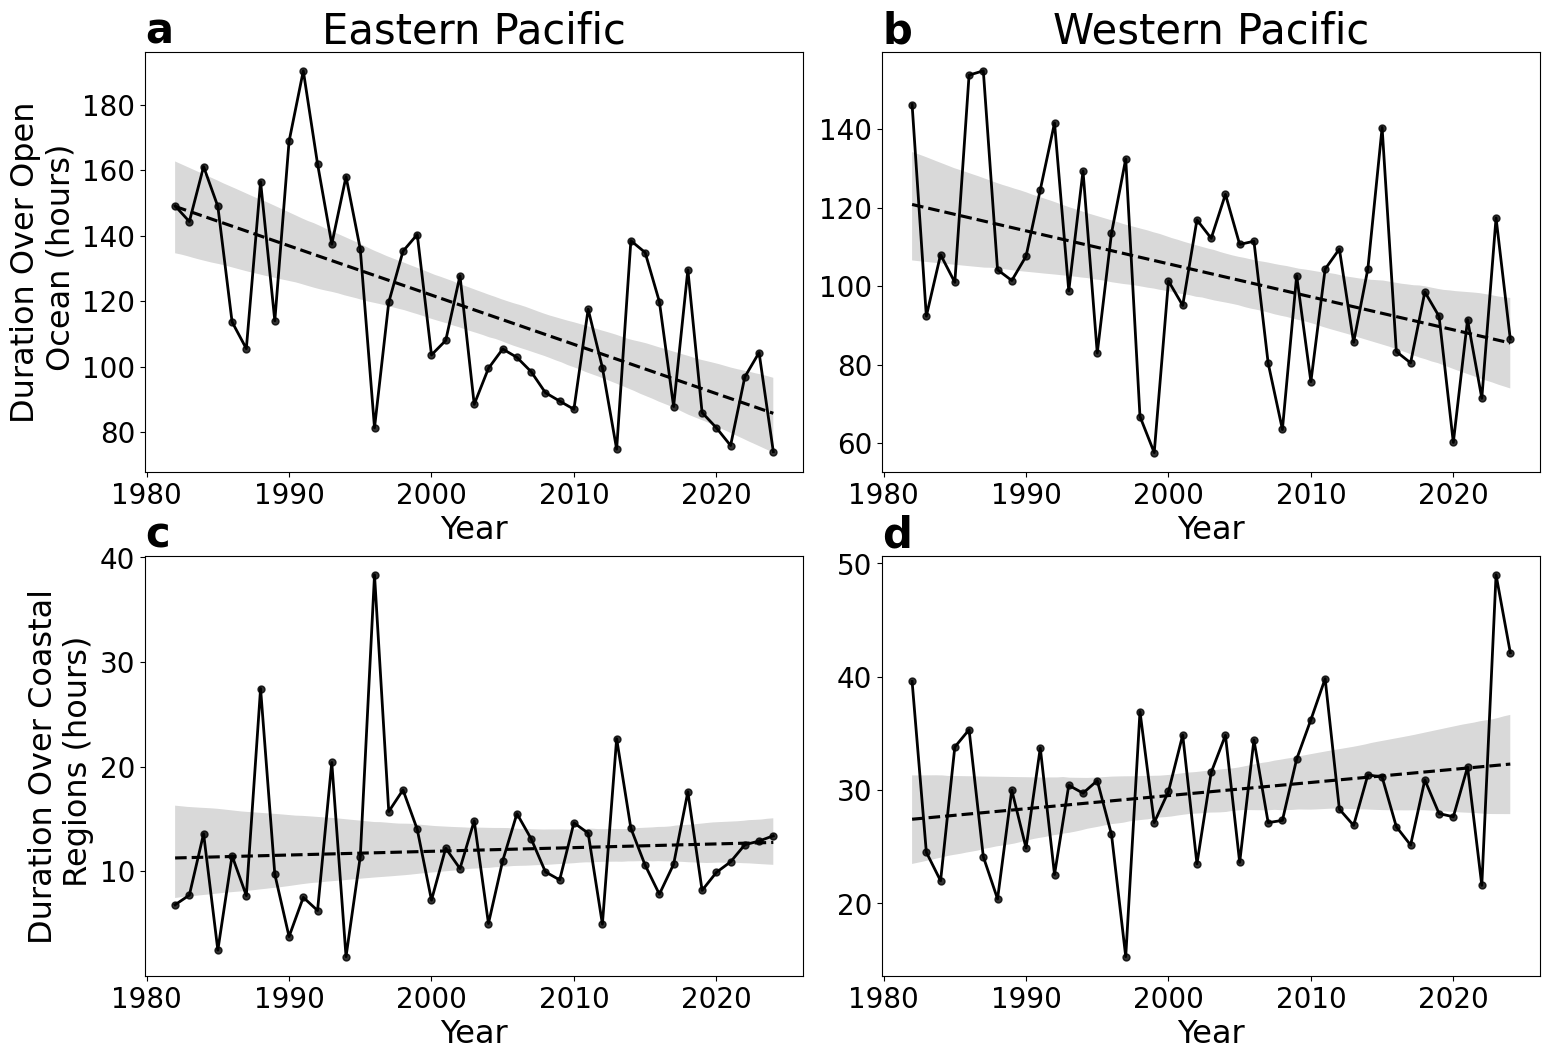

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

plot_timeseries(EP_coastal, 'offshore', axs, 0, 0, False)
axs[0, 0].set_title('Eastern Pacific', fontsize=30)
axs[0, 0].set_xlabel('Year', fontsize=23)
axs[0, 0].set_ylabel('Duration Over Open\n Ocean (hours)', fontsize=23)
axs[0, 0].tick_params(axis='both', labelsize=20)
axs[0, 0].text(0, 1.02, 'a', transform=axs[0, 0].transAxes, fontsize=30, fontweight='bold')

plot_timeseries(WP_coastal, 'offshore', axs, 0, 1, False)
axs[0, 1].set_title('Western Pacific', fontsize=30)
axs[0, 1].set_xlabel('Year', fontsize=23)
axs[0, 1].set_ylabel('')
axs[0, 1].tick_params(axis='both', labelsize=20)
axs[0, 1].text(0, 1.02, 'b', transform=axs[0, 1].transAxes, fontsize=30, fontweight='bold')

plot_timeseries(EP_coastal, 'coastal', axs, 1, 0, False)
axs[1, 0].set_xlabel('Year', fontsize=23)
axs[1, 0].set_ylabel('Duration Over Coastal\n Regions (hours)', fontsize=23)
axs[1, 0].tick_params(axis='both', labelsize=20)
axs[1, 0].text(0, 1.02, 'c', transform=axs[1, 0].transAxes, fontsize=30, fontweight='bold')

plot_timeseries(WP_coastal, 'coastal', axs, 1, 1, False)
axs[1, 1].set_xlabel('Year', fontsize=23)
axs[1, 1].set_ylabel('')
axs[1, 1].tick_params(axis='both', labelsize=20)
axs[1, 1].text(0, 1.02, 'd', transform=axs[1, 1].transAxes, fontsize=30, fontweight='bold')

plt.subplots_adjust(hspace=0.2, wspace=0.12)      

plt.savefig('figures/coastal.png', dpi=300, bbox_inches='tight')
plt.show()

y = -1.51x + 3156.99, p-value = 0.000, confidence interval = -2.07 - -0.96, interval width = 0.56
y = -0.81x + 1743.71, p-value = 0.007, confidence interval = -1.39 - -0.24, interval width = 0.57
y = 0.05x + -91.49, p-value = 0.293, confidence interval = -0.04 - 0.14, interval width = 0.09
y = 0.09x + -164.75, p-value = 0.050, confidence interval = 0.00 - 0.18, interval width = 0.09


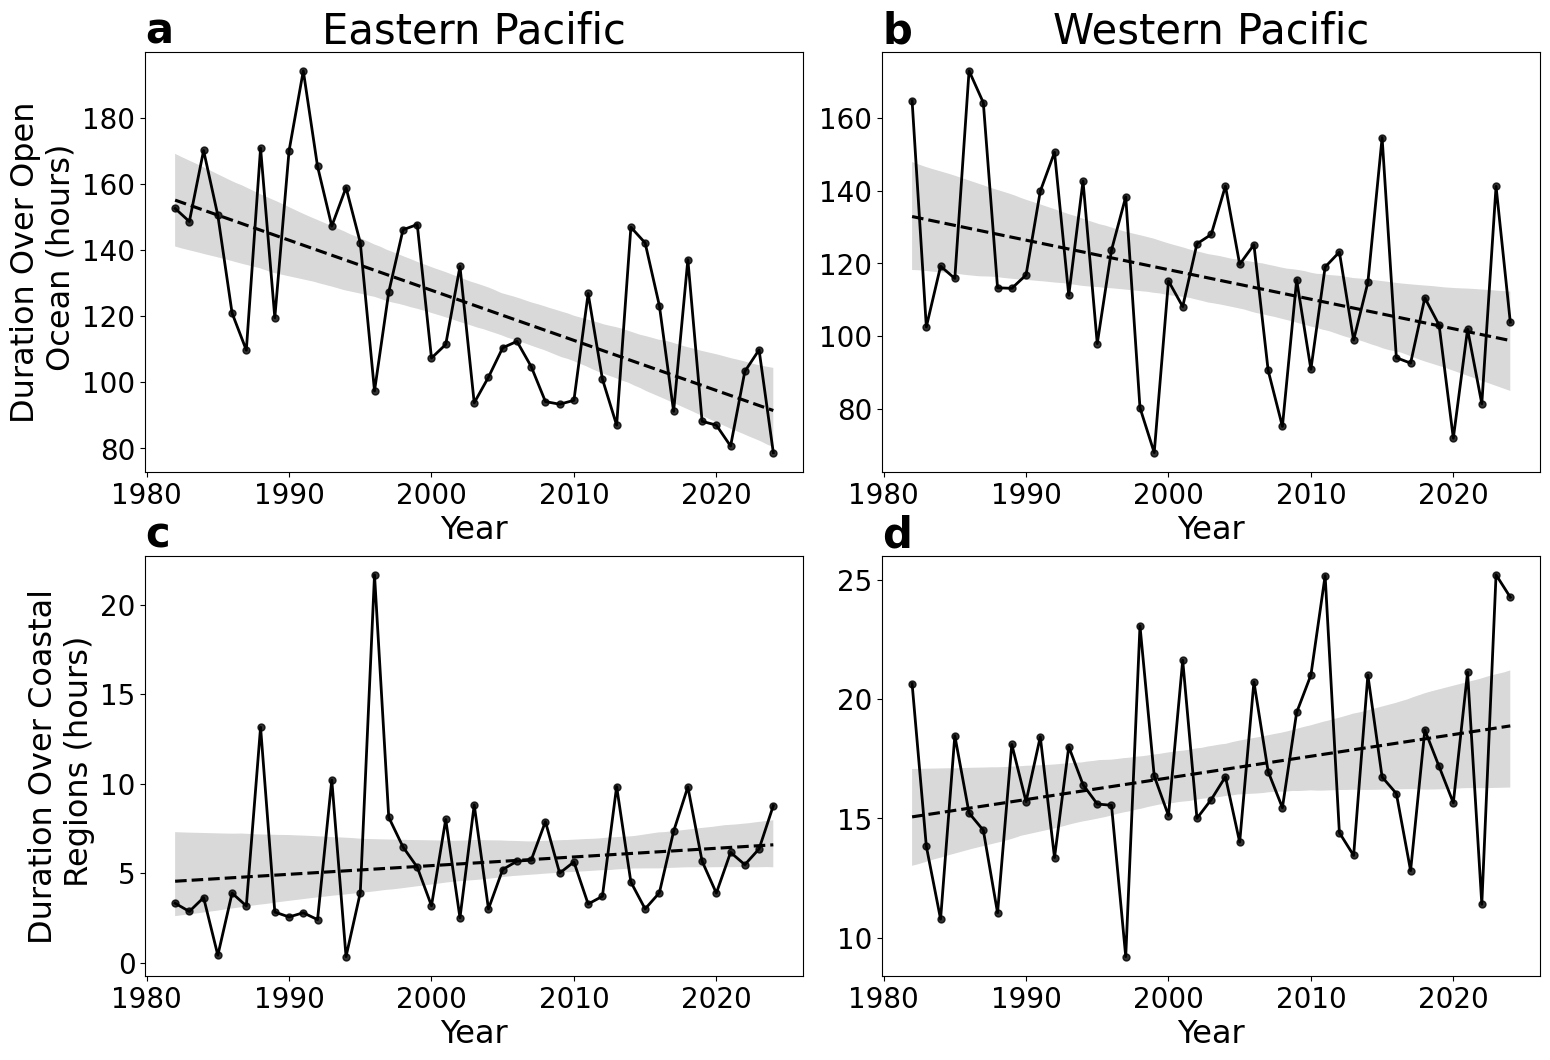

y = -1.52x + 3166.92, p-value = 0.000, confidence interval = -2.08 - -0.96, interval width = 0.56
y = -0.82x + 1755.35, p-value = 0.005, confidence interval = -1.38 - -0.26, interval width = 0.56
y = 0.06x + -103.41, p-value = 0.405, confidence interval = -0.08 - 0.19, interval width = 0.13
y = 0.10x + -175.75, p-value = 0.108, confidence interval = -0.02 - 0.22, interval width = 0.12


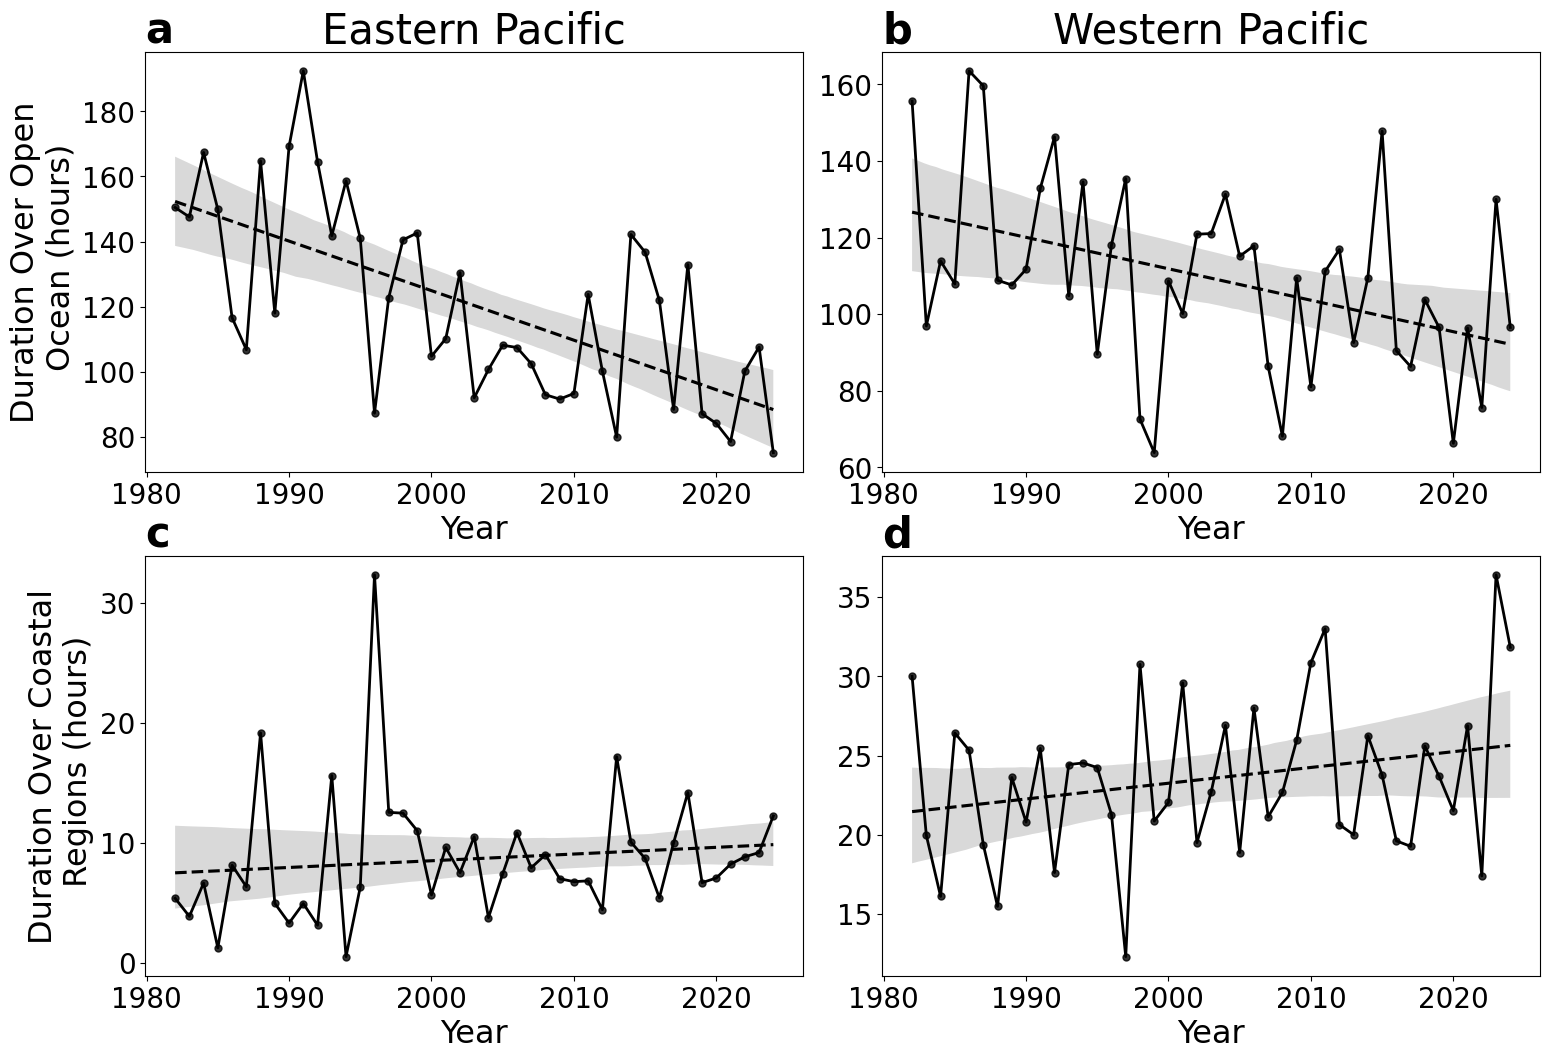

y = -1.50x + 3128.23, p-value = 0.000, confidence interval = -2.06 - -0.94, interval width = 0.56
y = -0.84x + 1787.35, p-value = 0.004, confidence interval = -1.39 - -0.29, interval width = 0.55
y = 0.04x + -58.76, p-value = 0.666, confidence interval = -0.13 - 0.20, interval width = 0.16
y = 0.12x + -202.20, p-value = 0.139, confidence interval = -0.04 - 0.27, interval width = 0.16


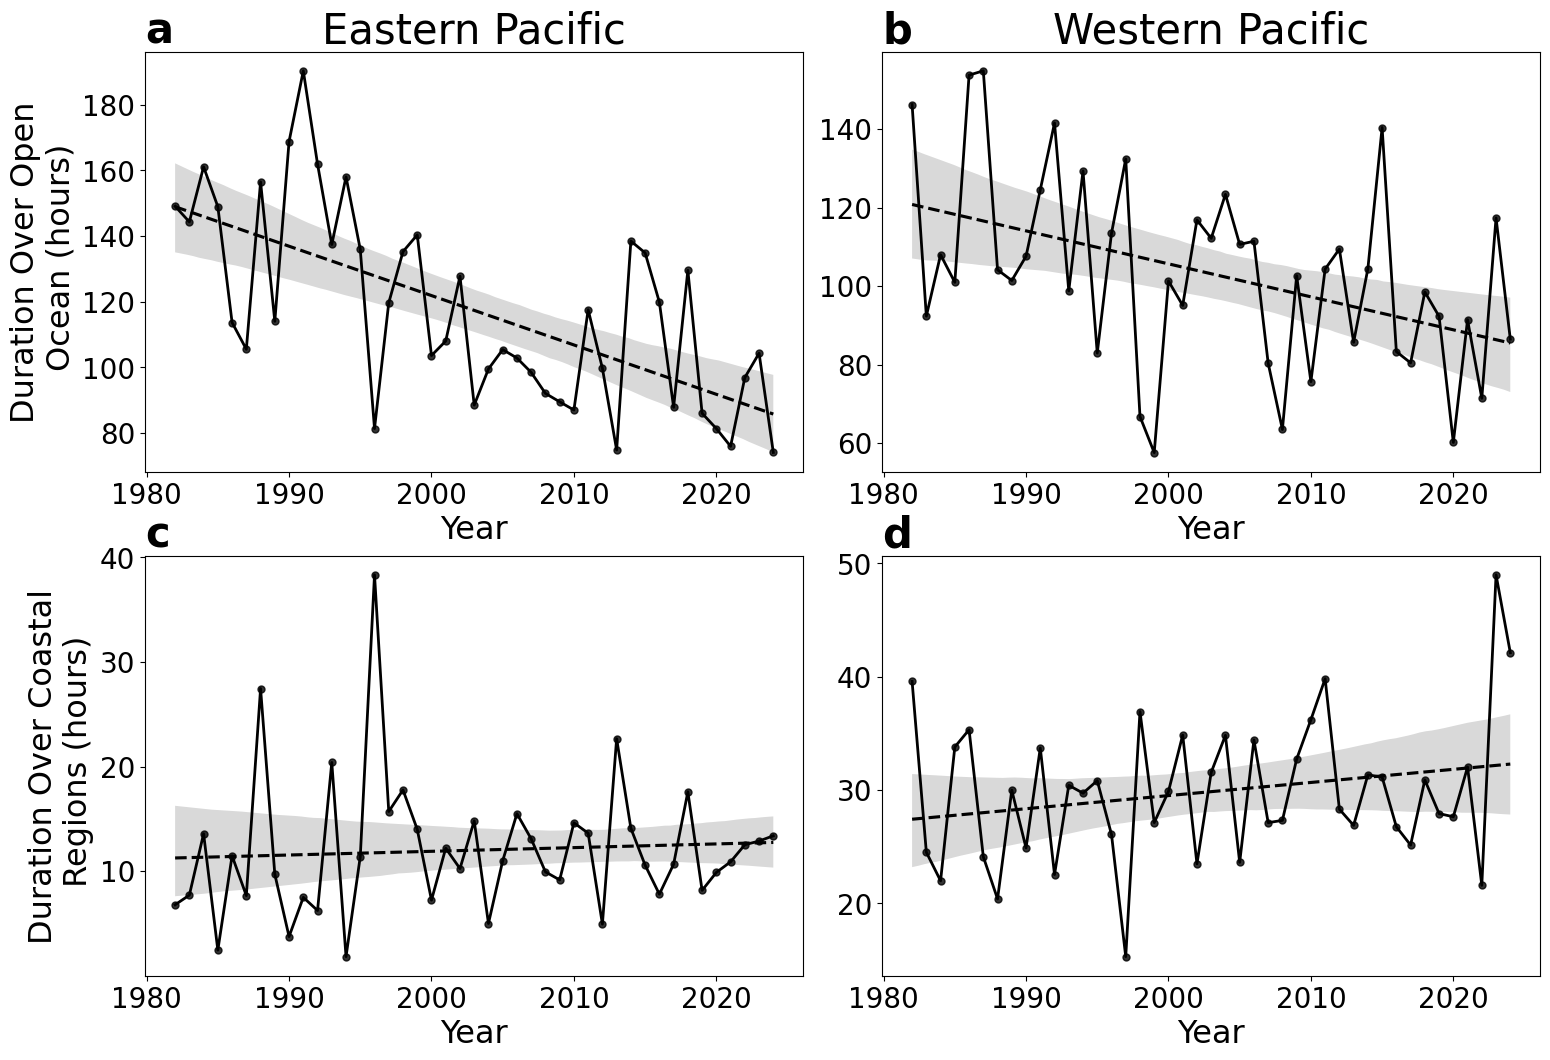

y = -1.46x + 3043.49, p-value = 0.000, confidence interval = -2.04 - -0.89, interval width = 0.57
y = -0.84x + 1774.62, p-value = 0.004, confidence interval = -1.38 - -0.29, interval width = 0.55
y = -0.00x + 22.17, p-value = 0.979, confidence interval = -0.22 - 0.22, interval width = 0.22
y = 0.11x + -190.24, p-value = 0.189, confidence interval = -0.06 - 0.28, interval width = 0.17


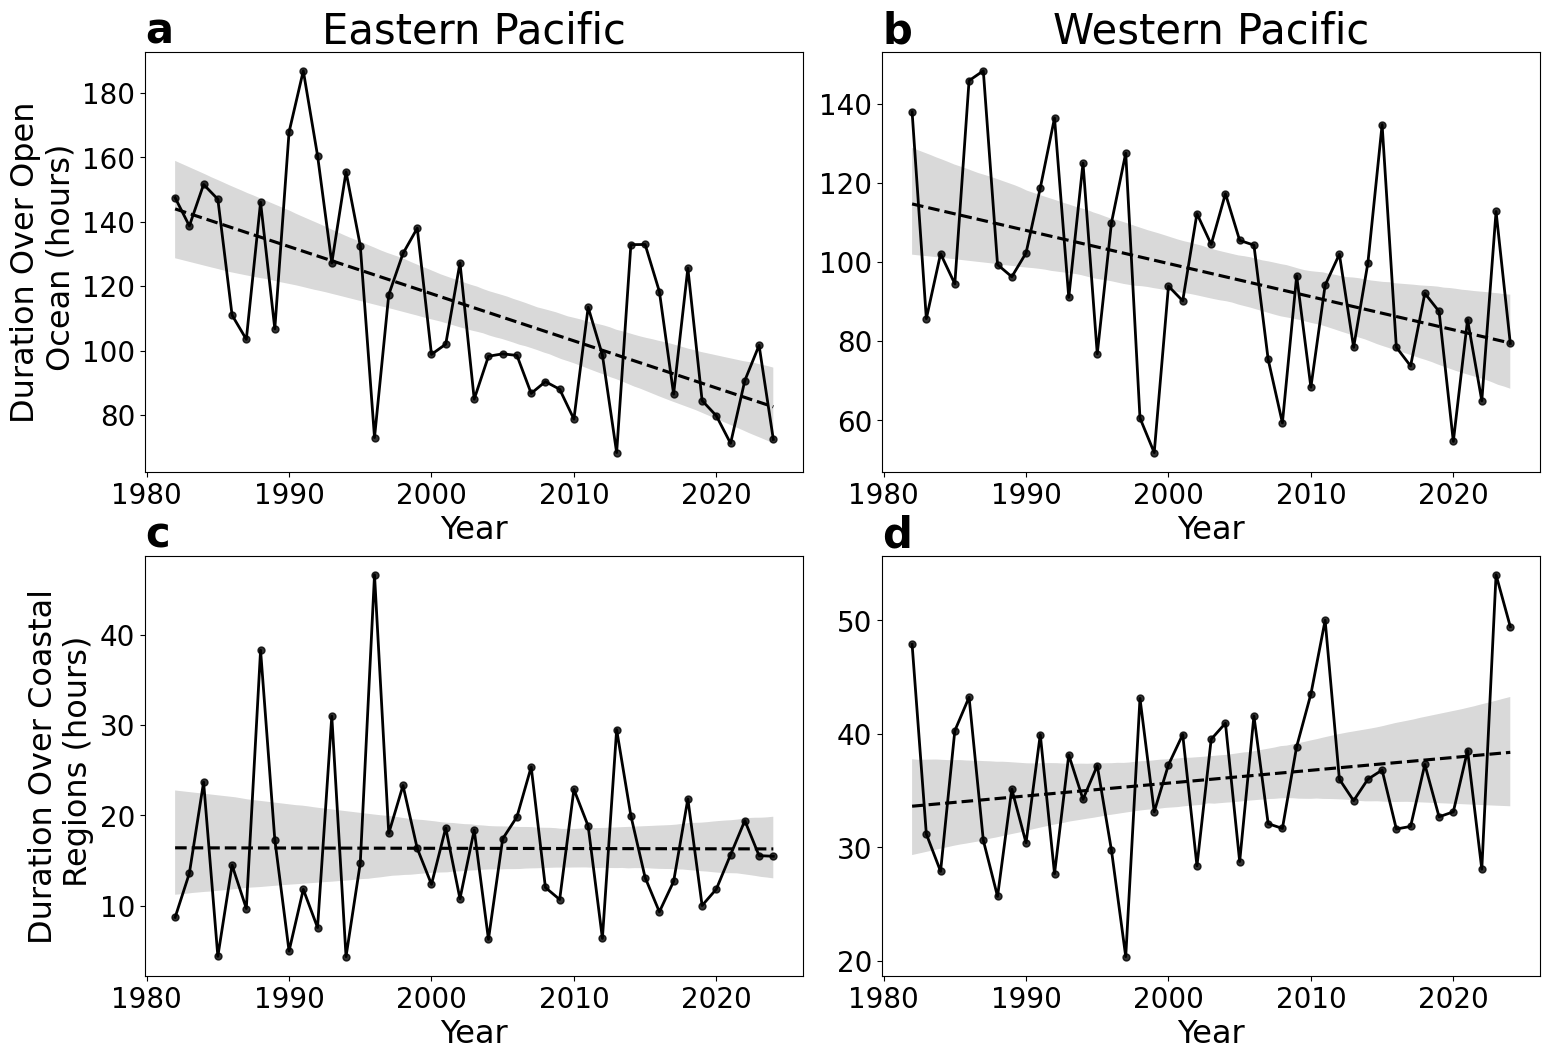

y = -1.42x + 2950.04, p-value = 0.000, confidence interval = -2.00 - -0.84, interval width = 0.58
y = -0.83x + 1764.38, p-value = 0.004, confidence interval = -1.38 - -0.29, interval width = 0.55
y = -0.05x + 110.51, p-value = 0.730, confidence interval = -0.31 - 0.22, interval width = 0.26
y = 0.11x + -180.67, p-value = 0.238, confidence interval = -0.08 - 0.30, interval width = 0.19


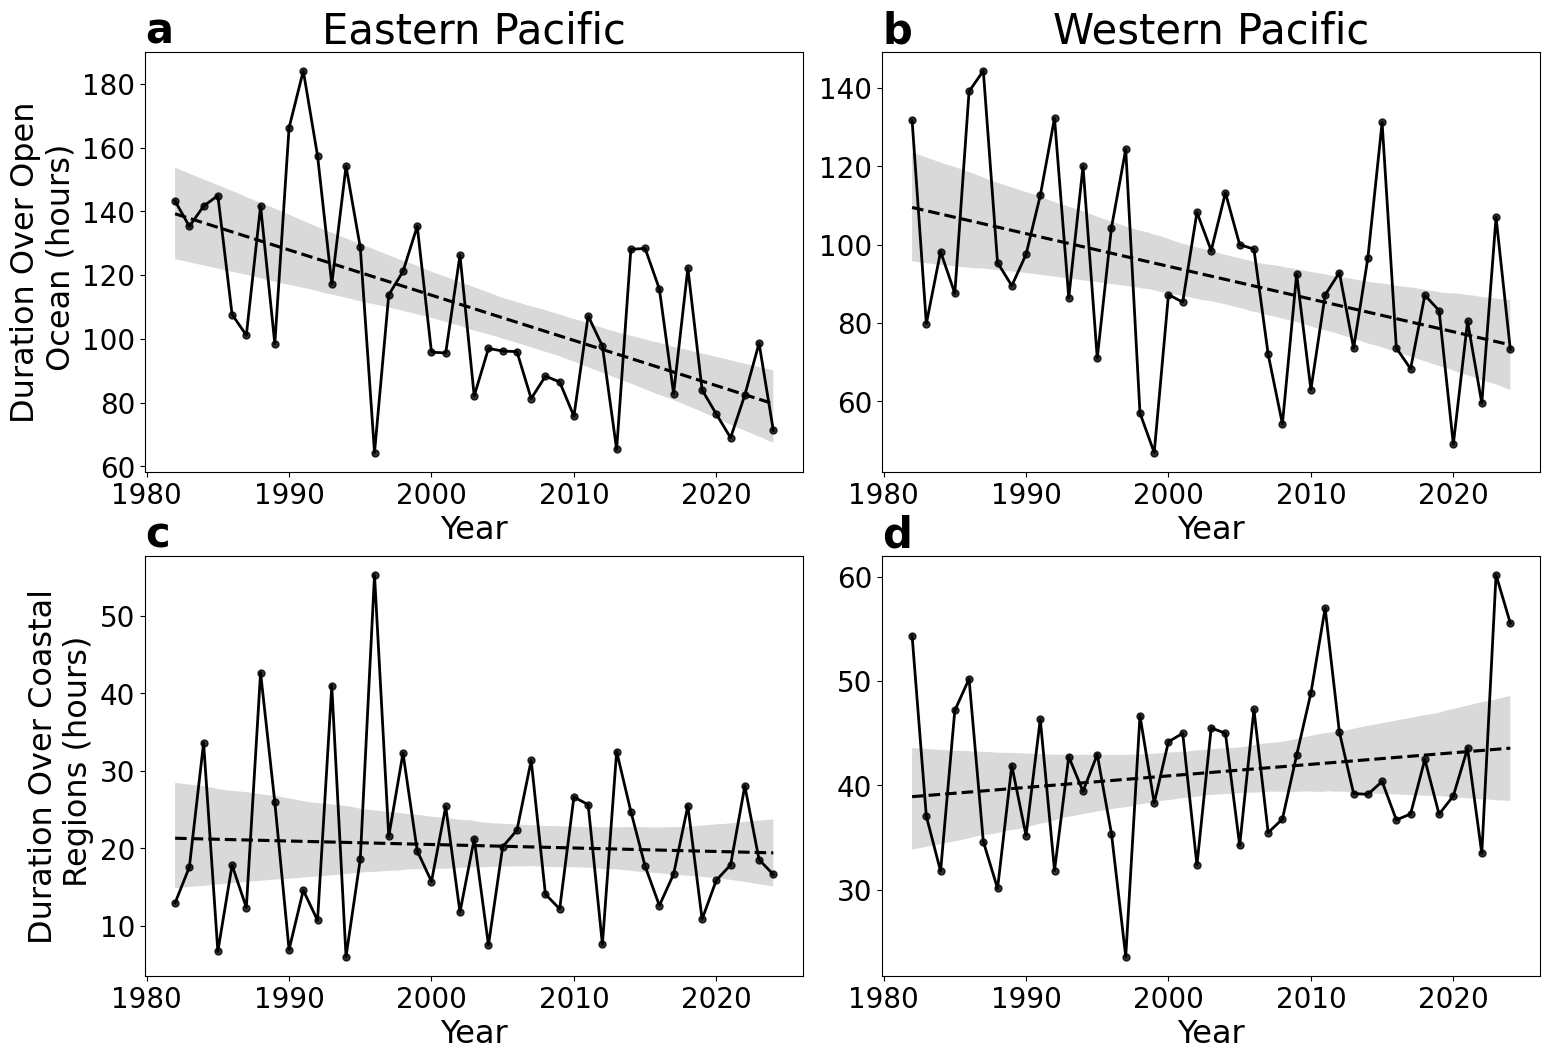

In [34]:
def check_coastal(distance):
    EP_coastal = duration_by_region('EP', distance)
    WP_coastal = duration_by_region('WP', distance)

    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    plot_timeseries(EP_coastal, 'offshore', axs, 0, 0, False)
    axs[0, 0].set_title('Eastern Pacific', fontsize=30)
    axs[0, 0].set_xlabel('Year', fontsize=23)
    axs[0, 0].set_ylabel('Duration Over Open\n Ocean (hours)', fontsize=23)
    axs[0, 0].tick_params(axis='both', labelsize=20)
    axs[0, 0].text(0, 1.02, 'a', transform=axs[0, 0].transAxes, fontsize=30, fontweight='bold')

    plot_timeseries(WP_coastal, 'offshore', axs, 0, 1, False)
    axs[0, 1].set_title('Western Pacific', fontsize=30)
    axs[0, 1].set_xlabel('Year', fontsize=23)
    axs[0, 1].set_ylabel('')
    axs[0, 1].tick_params(axis='both', labelsize=20)
    axs[0, 1].text(0, 1.02, 'b', transform=axs[0, 1].transAxes, fontsize=30, fontweight='bold')

    plot_timeseries(EP_coastal, 'coastal', axs, 1, 0, False)
    axs[1, 0].set_xlabel('Year', fontsize=23)
    axs[1, 0].set_ylabel('Duration Over Coastal\n Regions (hours)', fontsize=23)
    axs[1, 0].tick_params(axis='both', labelsize=20)
    axs[1, 0].text(0, 1.02, 'c', transform=axs[1, 0].transAxes, fontsize=30, fontweight='bold')

    plot_timeseries(WP_coastal, 'coastal', axs, 1, 1, False)
    axs[1, 1].set_xlabel('Year', fontsize=23)
    axs[1, 1].set_ylabel('')
    axs[1, 1].tick_params(axis='both', labelsize=20)
    axs[1, 1].text(0, 1.02, 'd', transform=axs[1, 1].transAxes, fontsize=30, fontweight='bold')

    plt.subplots_adjust(hspace=0.2, wspace=0.12)       
    plt.show()

check_coastal(100)
check_coastal(150)
check_coastal(200)
check_coastal(250)
check_coastal(300)

# Fig. S3: TC duration estimation using DELV and range

EP duration estimation correlation before LMI: 0.999, after LMI: 0.998
WP duration estimation correlation before LMI: 0.999, after LMI: 0.990


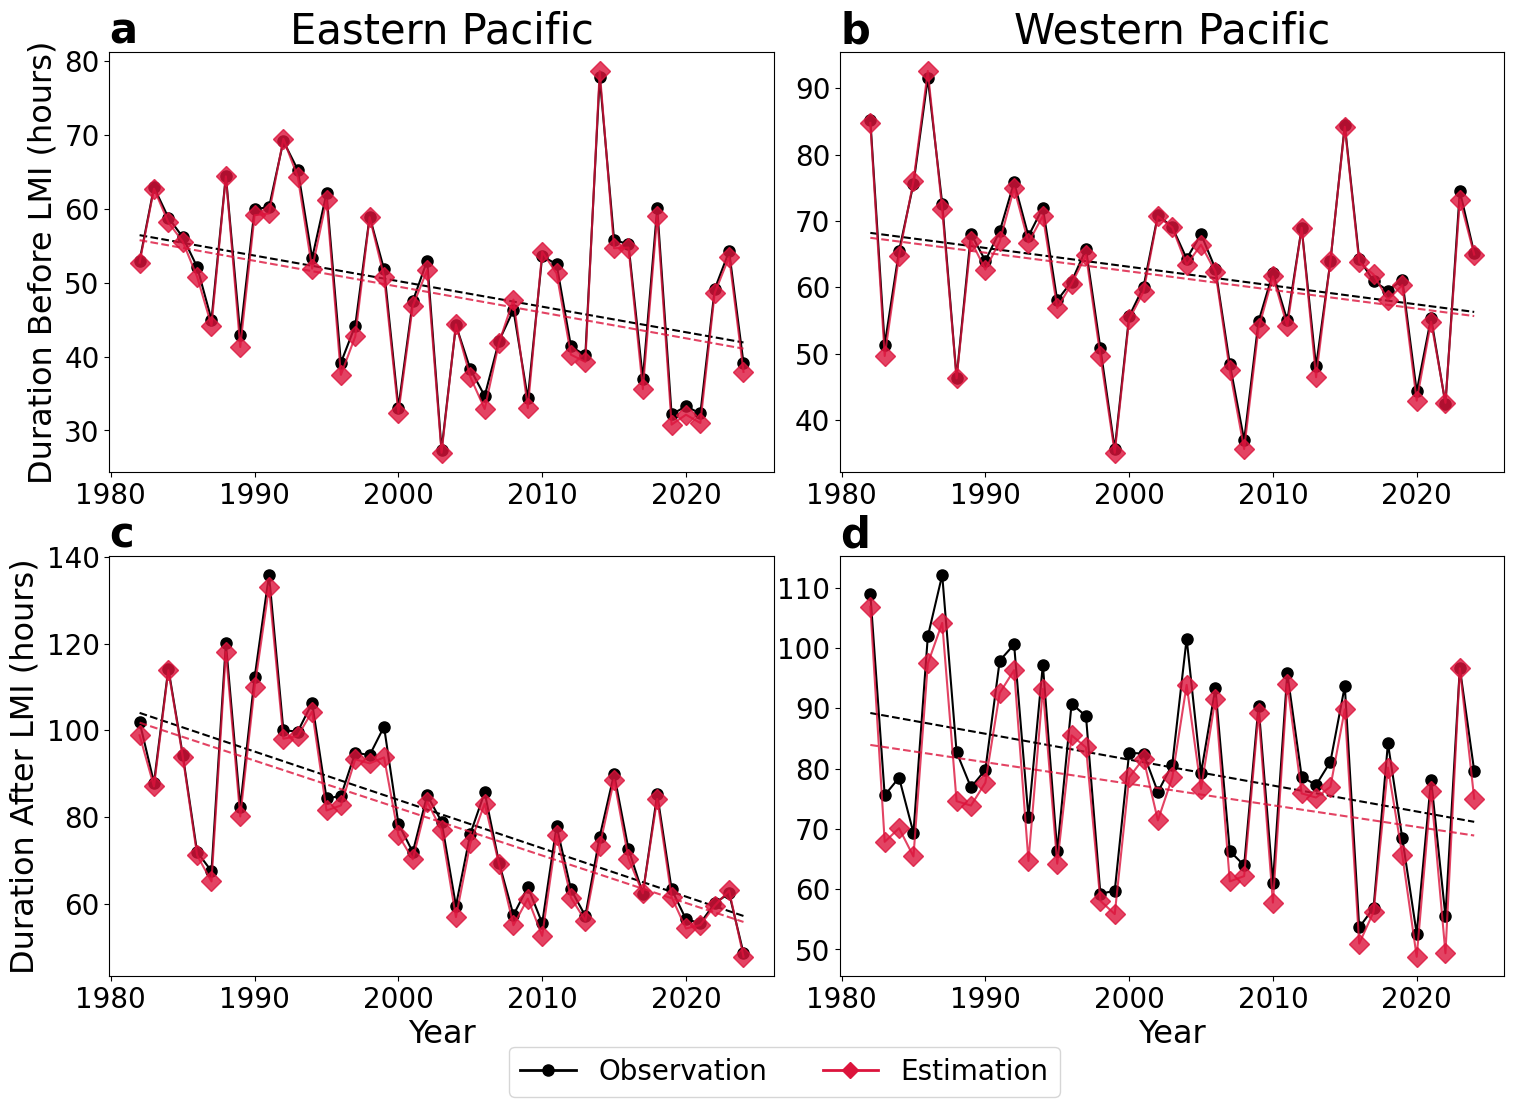

In [36]:
def compare_duration_estimation(basin, dt):
    properties_df = pd.read_csv('data/properties/properties_%s_202510.csv'%(basin))
    DELV_before_df = pd.read_csv('data/properties/DELV_before_LMI_%s_dt%s_202510.csv'%(basin, dt))
    DELV_after_df = pd.read_csv('data/properties/DELV_after_LMI_%s_dt%s_202510.csv'%(basin, dt))

    properties_yearly = properties_df.groupby('year')[['duration_before_LMI', 'intensity_range_1', 'duration_after_LMI', 'intensity_range_2']].mean().reset_index()
    DELV_before_yearly = DELV_before_df.groupby('YEAR')[['DELV']].mean().reset_index()
    DELV_after_yearly = DELV_after_df.groupby('YEAR')[['DELV']].mean().reset_index()

    duration_1_true = properties_yearly['duration_before_LMI']
    range_1_true = properties_yearly['intensity_range_1']
    DELV_1_true = DELV_before_yearly['DELV']
    duration_1_est = range_1_true / DELV_1_true * dt

    duration_2_true = properties_yearly['duration_after_LMI']
    range_2_true = properties_yearly['intensity_range_2']
    DELV_2_true = DELV_after_yearly['DELV']
    duration_2_est = range_2_true / DELV_2_true * dt * -1

    X = sm.add_constant(properties_yearly['year'].values)
    model_1_true = sm.OLS(duration_1_true, X).fit()
    duration_1_true_pred = model_1_true.predict(X)

    model_1_est = sm.OLS(duration_1_est, X).fit()
    duration_1_est_pred = model_1_est.predict(X)

    model_2_true = sm.OLS(duration_2_true, X).fit()
    duration_2_true_pred = model_2_true.predict(X)

    model_2_est = sm.OLS(duration_2_est, X).fit()
    duration_2_est_pred = model_2_est.predict(X)

    duration_1_corr = np.corrcoef(duration_1_true, duration_1_est)[0,1]
    duration_2_corr = np.corrcoef(duration_2_true, duration_2_est)[0,1]
    print(f'{basin} duration estimation correlation before LMI: {duration_1_corr:.3f}, after LMI: {duration_2_corr:.3f}')

    return properties_yearly['year'].values, duration_1_true, duration_1_true_pred, duration_1_est, duration_1_est_pred, duration_2_true, duration_2_true_pred, duration_2_est, duration_2_est_pred


EP_years, EP_1_true, EP_1_true_pred, EP_1_est, EP_1_est_pred, EP_2_true, EP_2_true_pred, EP_2_est, EP_2_est_pred = compare_duration_estimation('EP', 6)
WP_years, WP_1_true, WP_1_true_pred, WP_1_est, WP_1_est_pred, WP_2_true, WP_2_true_pred, WP_2_est, WP_2_est_pred = compare_duration_estimation('WP', 6)

estimate_color = '#DC143C'

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

axes[0, 0].plot(EP_years, EP_1_true, c='black', linestyle='-', marker='o', markersize=8)
axes[0, 0].plot(EP_years, EP_1_true_pred, c='black', linestyle='--')
axes[0, 0].plot(EP_years, EP_1_est, c=estimate_color, linestyle='-', marker='D', markersize=10, alpha=0.8)
axes[0, 0].plot(EP_years, EP_1_est_pred, c=estimate_color, alpha=0.8, linestyle='--')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Duration Before LMI (hours)', fontsize=23)
axes[0, 0].set_title('Eastern Pacific', fontsize=30)
axes[0, 0].tick_params(axis='both', labelsize=20)
axes[0, 0].text(0, 1.02, 'a', transform=axes[0, 0].transAxes, fontsize=30, fontweight='bold')

axes[1, 0].plot(EP_years, EP_2_true, c='black', linestyle='-', marker='o', markersize=8)
axes[1, 0].plot(EP_years, EP_2_true_pred, c='black', linestyle='--')
axes[1, 0].plot(EP_years, EP_2_est, c=estimate_color, linestyle='-', marker='D', markersize=10, alpha=0.8)
axes[1, 0].plot(EP_years, EP_2_est_pred, c=estimate_color, alpha=0.8, linestyle='--')
axes[1, 0].set_xlabel('Year', fontsize=23)
axes[1, 0].set_ylabel('Duration After LMI (hours)', fontsize=23)
axes[1, 0].tick_params(axis='both', labelsize=20)
axes[1, 0].text(0, 1.02, 'c', transform=axes[1, 0].transAxes, fontsize=30, fontweight='bold')

axes[0, 1].plot(WP_years, WP_1_true, c='black', linestyle='-', marker='o', markersize=8)
axes[0, 1].plot(WP_years, WP_1_true_pred, c='black', linestyle='--')
axes[0, 1].plot(WP_years, WP_1_est, c=estimate_color, linestyle='-', marker='D', markersize=10, alpha=0.8)
axes[0, 1].plot(WP_years, WP_1_est_pred, c=estimate_color, alpha=0.8, linestyle='--')
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].set_title('Western Pacific', fontsize=30)
axes[0, 1].tick_params(axis='both', labelsize=20)
axes[0, 1].text(0, 1.02, 'b', transform=axes[0, 1].transAxes, fontsize=30, fontweight='bold')

axes[1, 1].plot(WP_years, WP_2_true, c='black', linestyle='-', marker='o', markersize=8)
axes[1, 1].plot(WP_years, WP_2_true_pred, c='black', linestyle='--')
axes[1, 1].plot(WP_years, WP_2_est, c=estimate_color, linestyle='-', marker='D', markersize=10, alpha=0.8)
axes[1, 1].plot(WP_years, WP_2_est_pred, c=estimate_color, alpha=0.8, linestyle='--')
axes[1, 1].set_xlabel('Year', fontsize=23)
axes[1, 1].set_ylabel('')
axes[1, 1].tick_params(axis='both', labelsize=20)
axes[1, 1].text(0, 1.02, 'd', transform=axes[1, 1].transAxes, fontsize=30, fontweight='bold')

legend_elements = [Line2D([0], [0], color='black', linestyle='-', marker='o', markersize=8, label='Observation', linewidth=2), Line2D([0], [0], color=estimate_color, linestyle='-', marker='D', markersize=8, label='Estimation', linewidth=2)]
fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.03), ncol=2, fontsize=20)

plt.subplots_adjust(wspace=0.1)
plt.savefig('figures/duration_estimation_DELV.png', dpi=300, bbox_inches='tight')
plt.show()
        

# Fig. S4 Track length before/after LMI

In [21]:
def plot_track_trend(basin, dt):
    IB_data = pd.read_csv('processed_data/IBTrACS_%s_processed_dt3_202510.csv'%(basin))
    IB_data['ISO_TIME'] = pd.to_datetime(IB_data['ISO_TIME'])

    if dt == 6:           
        IB_data = IB_data[IB_data['ISO_TIME'].dt.hour.isin([0,6,12,18])].reset_index(drop=True)

    TC_track_df = pd.DataFrame(columns=['year', 'ID', 'track_length'])
    TC_speed_df = pd.DataFrame(columns=['year', 'ID', 'translation_speed'])
    TC_track_df_before = pd.DataFrame(columns=['year', 'ID', 'track_length'])
    TC_speed_df_before = pd.DataFrame(columns=['year', 'ID', 'translation_speed'])
    TC_track_df_after = pd.DataFrame(columns=['year', 'ID', 'track_length'])
    TC_speed_df_after = pd.DataFrame(columns=['year', 'ID', 'translation_speed'])

    ID_unique = sorted(IB_data['USA_ATCF_ID'].unique())

    for TC_ID in ID_unique:
        TC_ID_data = IB_data[IB_data['USA_ATCF_ID'] == TC_ID].sort_values(by='ISO_TIME').reset_index(drop=True)
        if len(TC_ID_data) > 0:
            TC_year = TC_ID_data['YEAR'].iloc[0]
            if len(TC_ID_data[TC_ID_data['COMBINE_WIND'] >= 34]) > 0:
                start_idx = TC_ID_data[TC_ID_data['COMBINE_WIND'] >= 34].index[0]
                if len(TC_ID_data[TC_ID_data['NATURE'] == 'TS']) > 0:    
                    end_idx = TC_ID_data[TC_ID_data['NATURE'] == 'TS'].index[-1]
                    if end_idx > start_idx:
                        TC_ID_data = TC_ID_data[start_idx:end_idx+1].reset_index(drop=True)
                        LMI_idx = TC_ID_data['COMBINE_WIND'].idxmax()
                        TC_ID_data['type'] = 'before'
                        TC_ID_data.loc[LMI_idx:, 'type'] = 'after'

                        track_length = 0
                        track_length_before = 0
                        track_length_after = 0
                        for i in range(len(TC_ID_data)-1):
                            point1 = (TC_ID_data.loc[i, 'LAT'], TC_ID_data.loc[i, 'LON'])
                            point2 = (TC_ID_data.loc[i+1, 'LAT'], TC_ID_data.loc[i+1, 'LON'])
                            distance = geodesic(point1, point2).kilometers
                            track_length += distance
                            if i < LMI_idx:
                                track_length_before += distance
                            else:
                                track_length_after += distance
                        TC_track_df = pd.concat([TC_track_df, pd.DataFrame({'year':[TC_year], 'ID':[TC_ID], 'track_length':[track_length]})], ignore_index=True)
                        TC_track_df_before = pd.concat([TC_track_df_before, pd.DataFrame({'year':[TC_year], 'ID':[TC_ID], 'track_length':[track_length_before]})], ignore_index=True)
                        TC_track_df_after = pd.concat([TC_track_df_after, pd.DataFrame({'year':[TC_year], 'ID':[TC_ID], 'track_length':[track_length_after]})], ignore_index=True)



                        TC_ID_DT = TC_ID_data[['ISO_TIME', 'LAT', 'LON']]
                        TC_ID_DT['ISO_TIME'] = TC_ID_DT['ISO_TIME'] - pd.Timedelta(hours=dt)
                        TC_ID_DT.rename(columns={'LAT':'LAT_DT', 'LON':'LON_DT'}, inplace=True)
                        TC_ID_speed = pd.merge(TC_ID_data, TC_ID_DT, on='ISO_TIME', how='inner')
                        if len(TC_ID_speed) > 0:
                            TC_ID_speed['translation_speed'] = TC_ID_speed.apply(lambda row: geodesic((row['LAT'], row['LON']), (row['LAT_DT'], row['LON_DT'])).kilometers / dt, axis=1)
                            TC_speed_df = pd.concat([TC_speed_df, TC_ID_speed[['YEAR', 'USA_ATCF_ID', 'translation_speed']].rename(columns={'YEAR':'year', 'USA_ATCF_ID':'ID'})], ignore_index=True)
                            if len(TC_ID_speed[TC_ID_speed['type'] == 'before']) > 0:
                                TC_speed_df_before = pd.concat([TC_speed_df_before, TC_ID_speed[TC_ID_speed['type'] == 'before'][['YEAR', 'USA_ATCF_ID', 'translation_speed']].rename(columns={'YEAR':'year', 'USA_ATCF_ID':'ID'})], ignore_index=True)
                            if len(TC_ID_speed[TC_ID_speed['type'] == 'after']) > 0:
                                TC_speed_df_after = pd.concat([TC_speed_df_after, TC_ID_speed[TC_ID_speed['type'] == 'after'][['YEAR', 'USA_ATCF_ID', 'translation_speed']].rename(columns={'YEAR':'year', 'USA_ATCF_ID':'ID'})], ignore_index=True)
    
    return TC_track_df, TC_speed_df, TC_track_df_before, TC_speed_df_before, TC_track_df_after, TC_speed_df_after

In [22]:
EP_track_df, EP_speed_df, EP_track_df_before, EP_speed_df_before, EP_track_df_after, EP_speed_df_after = plot_track_trend('EP', 3)
WP_track_df, WP_speed_df, WP_track_df_before, WP_speed_df_before, WP_track_df_after, WP_speed_df_after = plot_track_trend('WP', 3)


y = -7.17x + 15164.10, p-value = 0.004, confidence interval = -11.86 - -2.47, interval width = 4.70
y = -4.37x + 9828.78, p-value = 0.113, confidence interval = -9.82 - 1.08, interval width = 5.45
y = -17.92x + 37200.39, p-value = 0.000, confidence interval = -25.27 - -10.56, interval width = 7.36
y = -10.84x + 23355.60, p-value = 0.002, confidence interval = -17.57 - -4.11, interval width = 6.73


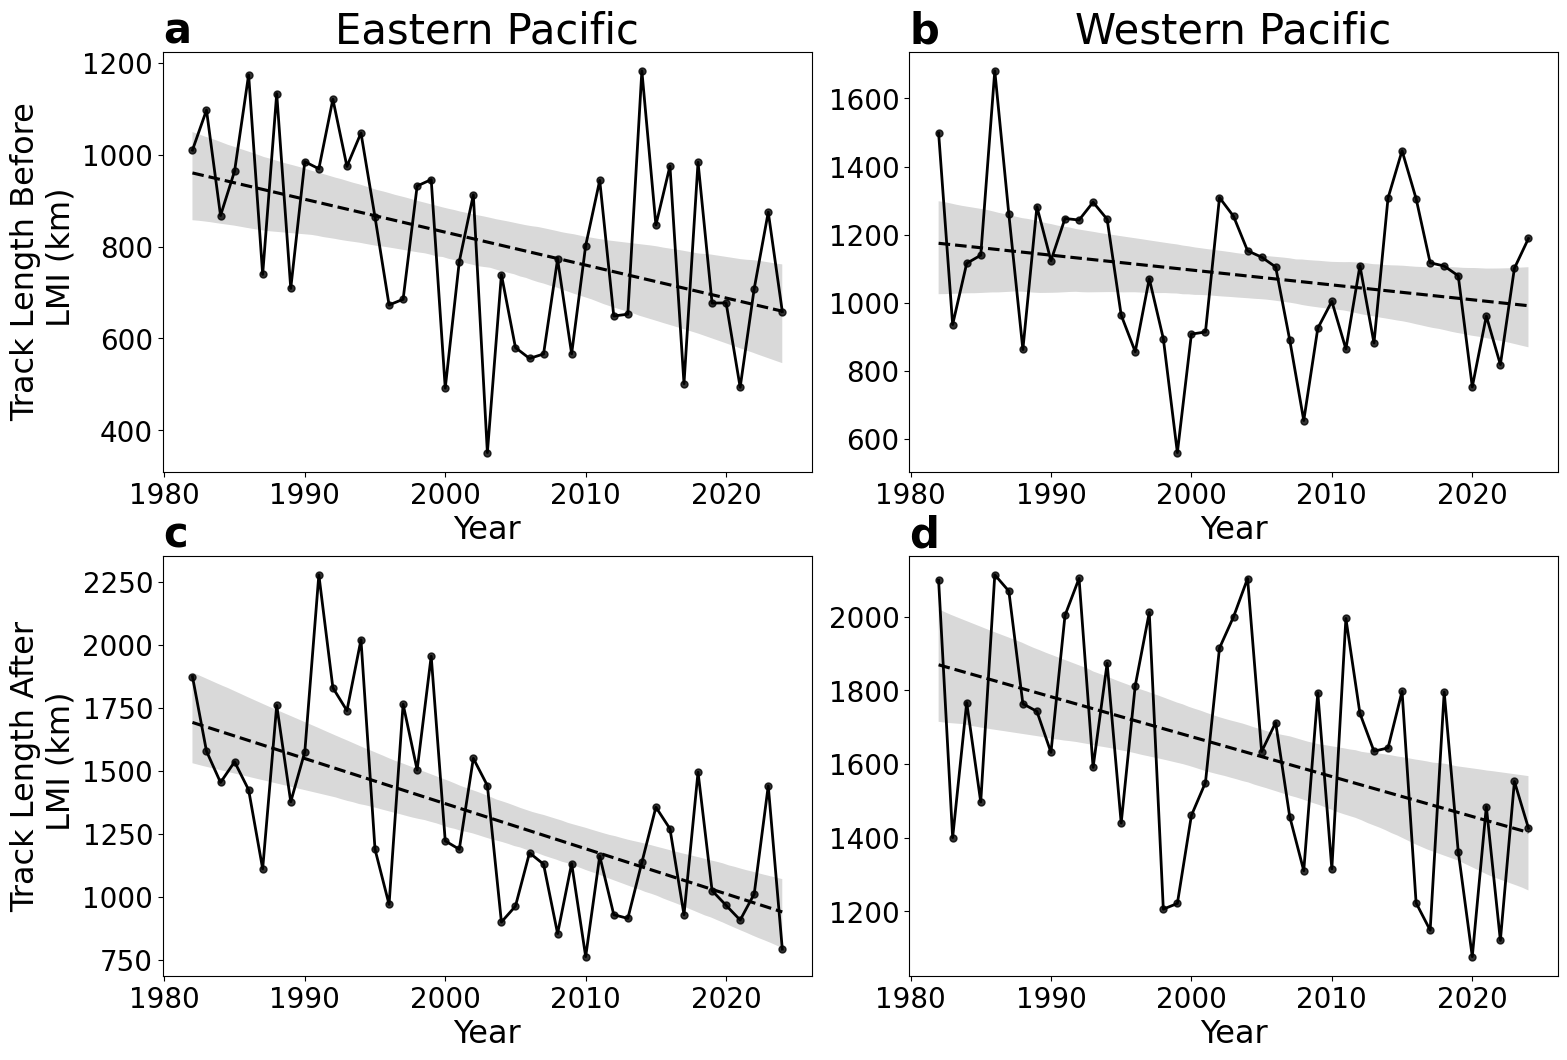

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

plot_timeseries(EP_track_df_before, 'track_length', axs, 0, 0, False)
axs[0, 0].set_title('Eastern Pacific', fontsize=30)
axs[0, 0].set_xlabel('Year', fontsize=23)
axs[0, 0].set_ylabel('Track Length Before\n LMI (km)', fontsize=23)
axs[0, 0].tick_params(axis='both', labelsize=20)
axs[0, 0].text(0, 1.02, 'a', transform=axs[0, 0].transAxes, fontsize=30, fontweight='bold')

plot_timeseries(WP_track_df_before, 'track_length', axs, 0, 1, False)
axs[0, 1].set_title('Western Pacific', fontsize=30)
axs[0, 1].set_xlabel('Year', fontsize=23)
axs[0, 1].set_ylabel('')
axs[0, 1].tick_params(axis='both', labelsize=20)
axs[0, 1].text(0, 1.02, 'b', transform=axs[0, 1].transAxes, fontsize=30, fontweight='bold')

plot_timeseries(EP_track_df_after, 'track_length', axs, 1, 0, False)
axs[1, 0].set_xlabel('Year', fontsize=23)
axs[1, 0].set_ylabel('Track Length After\n LMI (km)', fontsize=23)
axs[1, 0].tick_params(axis='both', labelsize=20)
axs[1, 0].text(0, 1.02, 'c', transform=axs[1, 0].transAxes, fontsize=30, fontweight='bold')

plot_timeseries(WP_track_df_after, 'track_length', axs, 1, 1, False)
axs[1, 1].set_xlabel('Year', fontsize=23)
axs[1, 1].set_ylabel('')
axs[1, 1].tick_params(axis='both', labelsize=20)
axs[1, 1].text(0, 1.02, 'd', transform=axs[1, 1].transAxes, fontsize=30, fontweight='bold')

plt.subplots_adjust(hspace=0.2, wspace=0.15)       

plt.savefig('figures/track_length_by_LMI.png', dpi=300, bbox_inches='tight')
plt.show()

# Fig. S5: Background and cold cloud SDBT trends

In [45]:
def plot_timeseries_missing(df, col, axs, i, j, single_row):
    all_years = df['year'].unique()
    yearly_mean = df.groupby('year')[col].mean().reset_index().dropna()
    years = yearly_mean['year'].values.reshape(-1)
    values = yearly_mean[col].values.reshape(-1)

    if single_row:
        ax = axs[i]
    else:
        ax = axs[i, j]

    sns.regplot(data=yearly_mean, x='year', y=col, ax=ax, scatter=True, ci=95, scatter_kws={'s':25, 'color':'black'}, line_kws={'color':'black', 'linestyle':'--'})    # ci is the confidence interval for regression line, not for individual years
    ax.plot(years, values, linewidth=2, c='black')

    X = sm.add_constant(years)
    model = sm.OLS(values, X).fit()
    slope = model.params[1]
    conf_int = model.conf_int(alpha=0.05)  # alpha=0.05 gives 95% CI
    slope_ci_lower = conf_int[1, 0]  # Lower bound for slope
    slope_ci_upper = conf_int[1, 1]  # Upper bound for slope
    intercept = model.params[0]
    p_value = model.pvalues[1]
    print(f'y = {slope:.2f}x + {intercept:.2f}, p-value = {p_value:.3f}, confidence interval = {slope_ci_lower:.2f} - {slope_ci_upper:.2f}, interval width = {(slope_ci_upper - slope_ci_lower)/2:.2f}')
    

    missing_years = np.setdiff1d(all_years, years)
    print(f'Missing years: {missing_years}')
    if len(missing_years) > 0:
        predicted = intercept + slope * missing_years
        ax.scatter(missing_years, predicted, marker='x', color='g', s=100)

    return years, values

y = -0.00x + 20.15, p-value = 0.873, confidence interval = -0.02 - 0.01, interval width = 0.01
y = 0.01x + 3.81, p-value = 0.398, confidence interval = -0.01 - 0.03, interval width = 0.02
y = -0.01x + 31.68, p-value = 0.111, confidence interval = -0.03 - 0.00, interval width = 0.02
Missing years: [1983 1988 1989 1992 1996 1998 2000 2001 2005 2009 2010 2011 2017 2021
 2022]
y = -0.02x + 36.62, p-value = 0.003, confidence interval = -0.03 - -0.01, interval width = 0.01
Missing years: [1992 1996 1997]
y = -0.00x + 13.60, p-value = 0.813, confidence interval = -0.01 - 0.01, interval width = 0.01
y = -0.02x + 43.66, p-value = 0.074, confidence interval = -0.03 - 0.00, interval width = 0.02


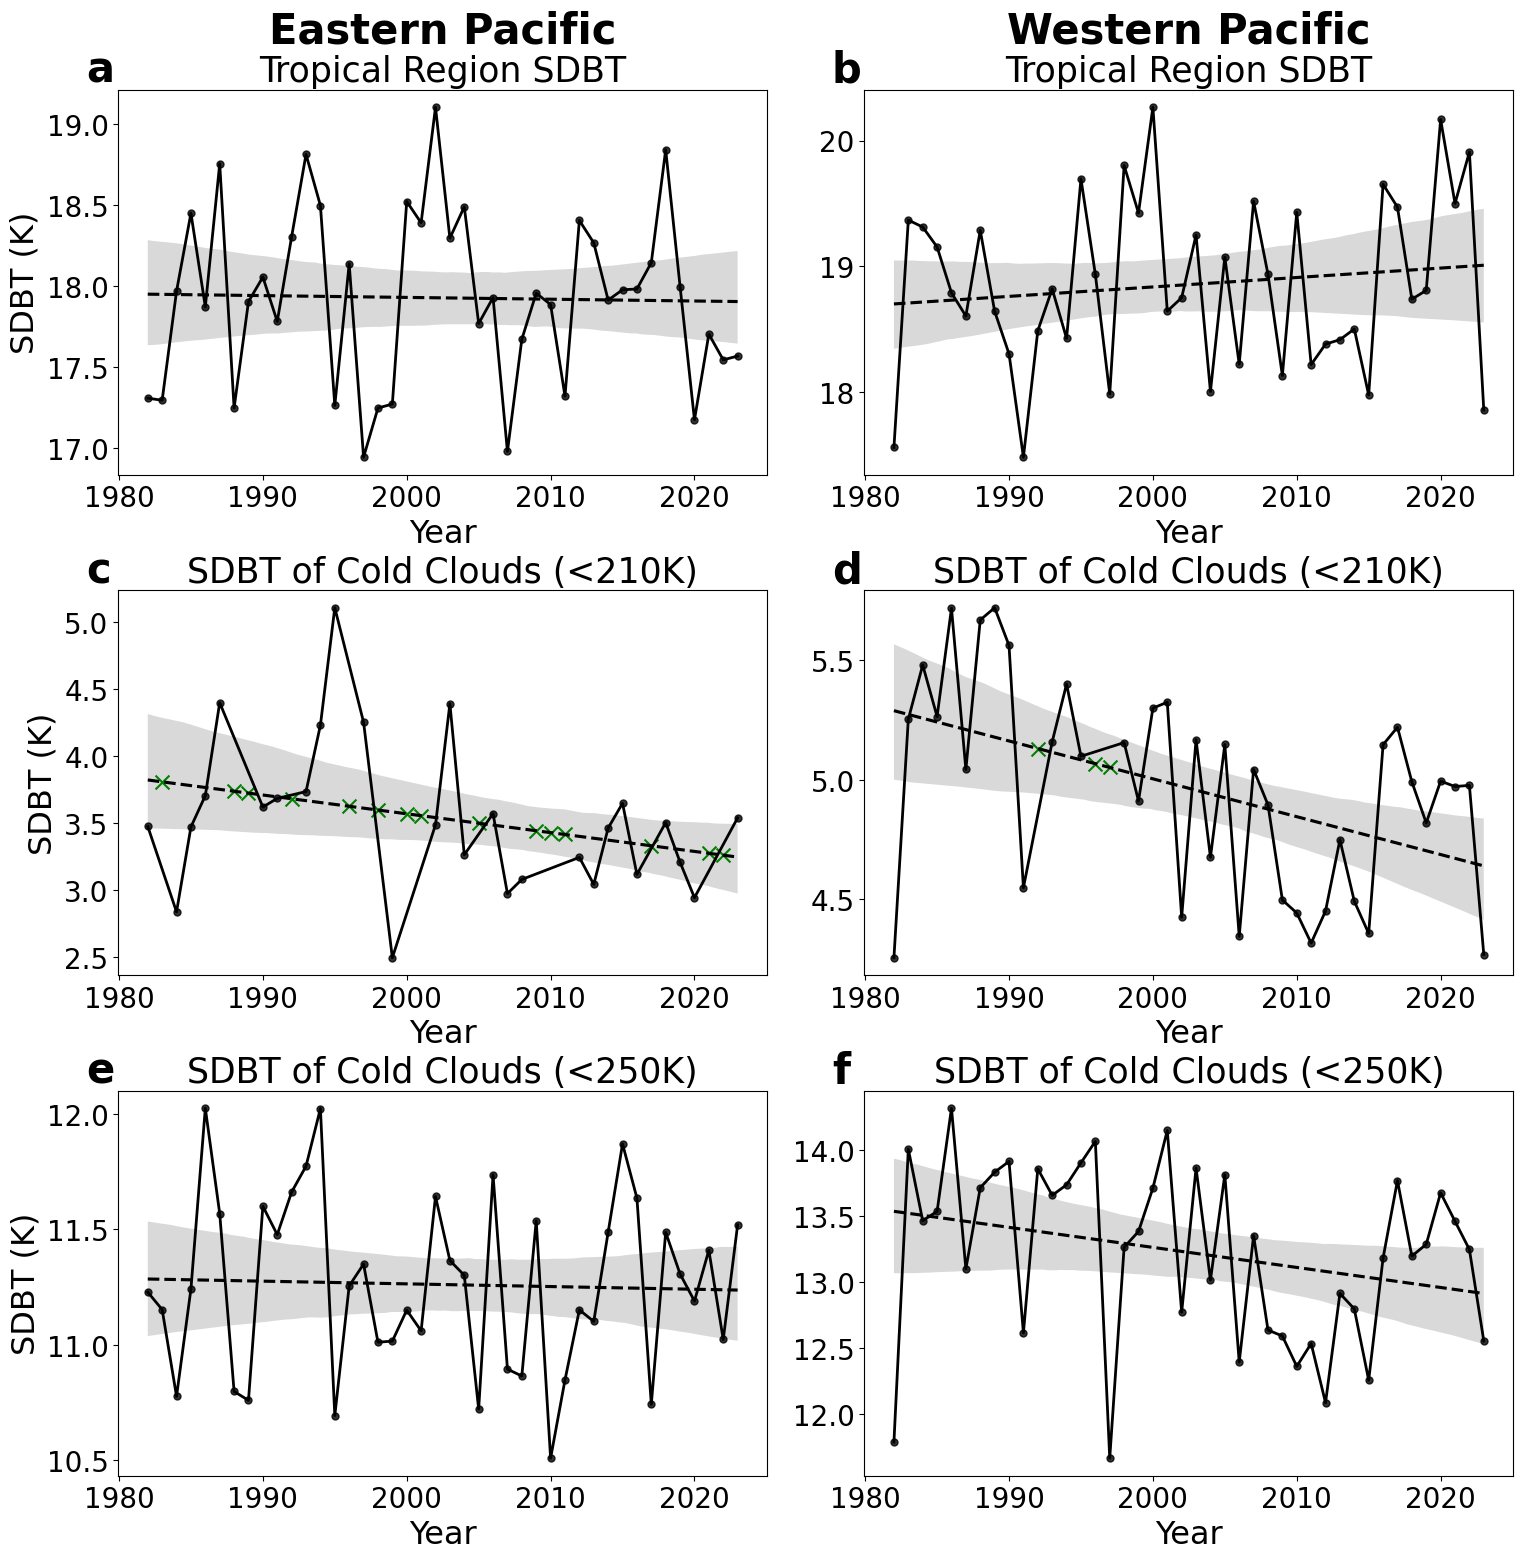

In [46]:
years = np.arange(1982, 2024)
SDBT_df = pd.DataFrame(columns=['year', 'SDBT_EP', 'SDBT_WP', 'SDBT_EP_210K', 'SDBT_WP_210K', 'SDBT_EP_250K', 'SDBT_WP_250K'])

for year in years:
    SDBT_EP = np.load('data/GridSat/EP/SDBT_EP_%s.npy'%(year))
    SDBT_WP = np.load('data/GridSat/WP/SDBT_WP_%s.npy'%(year))
    SDBT_EP_210K = np.load('data/GridSat/EP_210/SDBT_cold_EP_%s_210.npy'%(year))
    SDBT_WP_210K = np.load('data/GridSat/WP_210/SDBT_cold_WP_%s_210.npy'%(year))
    SDBT_EP_250K = np.load('data/GridSat/EP_250/SDBT_cold_EP_%s_250.npy'%(year))
    SDBT_WP_250K = np.load('data/GridSat/WP_250/SDBT_cold_WP_%s_250.npy'%(year))
    SDBT_df = pd.concat([SDBT_df, pd.DataFrame({'year':[year], 'SDBT_EP':[np.mean(SDBT_EP[0])], 'SDBT_WP':[np.mean(SDBT_WP[0])], 'SDBT_EP_210K':[np.mean(SDBT_EP_210K[0])], 'SDBT_WP_210K':[np.mean(SDBT_WP_210K[0])], 'SDBT_EP_250K':[np.mean(SDBT_EP_250K[0])], 'SDBT_WP_250K':[np.mean(SDBT_WP_250K[0])]})], ignore_index=True)

fig, axs = plt.subplots(3, 2, figsize=(18, 18))

plot_timeseries(SDBT_df, 'SDBT_EP', axs, 0, 0, False)
axs[0, 0].set_title('Tropical Region SDBT', fontsize=25)
axs[0, 0].text(0.5, 1.10, 'Eastern Pacific', transform=axs[0, 0].transAxes, fontsize=30, fontweight='bold', ha='center', va='bottom')
axs[0, 0].set_xlabel('Year', fontsize=23)
axs[0, 0].set_ylabel('SDBT (K)', fontsize=23)
axs[0, 0].tick_params(axis='both', labelsize=20)
axs[0, 0].text(-0.05, 1.02, 'a', transform=axs[0, 0].transAxes, fontsize=30, fontweight='bold')

plot_timeseries(SDBT_df, 'SDBT_WP', axs, 0, 1, False)
axs[0, 1].set_title('Tropical Region SDBT', fontsize=25)
axs[0, 1].text(0.5, 1.10, 'Western Pacific', transform=axs[0, 1].transAxes, fontsize=30, fontweight='bold', ha='center', va='bottom')
axs[0, 1].set_xlabel('Year', fontsize=23)
axs[0, 1].set_ylabel('')
axs[0, 1].tick_params(axis='both', labelsize=20)
axs[0, 1].text(-0.05, 1.02, 'b', transform=axs[0, 1].transAxes, fontsize=30, fontweight='bold')

plot_timeseries_missing(SDBT_df, 'SDBT_EP_210K', axs, 1, 0, False)
axs[1, 0].set_title('SDBT of Cold Clouds (<210K)', fontsize=25)
axs[1, 0].set_xlabel('Year', fontsize=23)
axs[1, 0].set_ylabel('SDBT (K)', fontsize=23)
axs[1, 0].tick_params(axis='both', labelsize=20)
axs[1, 0].text(-0.05, 1.02, 'c', transform=axs[1, 0].transAxes, fontsize=30, fontweight='bold')

plot_timeseries_missing(SDBT_df, 'SDBT_WP_210K', axs, 1, 1, False)
axs[1, 1].set_title('SDBT of Cold Clouds (<210K)', fontsize=25)
axs[1, 1].set_xlabel('Year', fontsize=23)
axs[1, 1].set_ylabel('')
axs[1, 1].tick_params(axis='both', labelsize=20)
axs[1, 1].text(-0.05, 1.02, 'd', transform=axs[1, 1].transAxes, fontsize=30, fontweight='bold')

plot_timeseries(SDBT_df, 'SDBT_EP_250K', axs, 2, 0, False)
axs[2, 0].set_title('SDBT of Cold Clouds (<250K)', fontsize=25)
axs[2, 0].set_xlabel('Year', fontsize=23)
axs[2, 0].set_ylabel('SDBT (K)', fontsize=23)
axs[2, 0].tick_params(axis='both', labelsize=20)
axs[2, 0].text(-0.05, 1.02, 'e', transform=axs[2, 0].transAxes, fontsize=30, fontweight='bold')

plot_timeseries(SDBT_df, 'SDBT_WP_250K', axs, 2, 1, False)
axs[2, 1].set_title('SDBT of Cold Clouds (<250K)', fontsize=25)
axs[2, 1].set_xlabel('Year', fontsize=23)
axs[2, 1].set_ylabel('')
axs[2, 1].tick_params(axis='both', labelsize=20)
axs[2, 1].text(-0.05, 1.02, 'f', transform=axs[2, 1].transAxes, fontsize=30, fontweight='bold')


plt.subplots_adjust(hspace=0.3, wspace=0.15)
plt.savefig('figures/SDBT_background.png', dpi=300, bbox_inches='tight')
plt.show()



# Fig. S6: PC2 trends before/after LMI

y = 0.53x + -1144.43, p-value = 0.065, confidence interval = -0.03 - 1.09, interval width = 0.56
y = 2.91x + -5972.79, p-value = 0.000, confidence interval = 1.79 - 4.04, interval width = 1.12
y = -1.36x + 2763.30, p-value = 0.000, confidence interval = -2.00 - -0.71, interval width = 0.64
y = 3.00x + -6082.99, p-value = 0.000, confidence interval = 2.00 - 4.01, interval width = 1.00


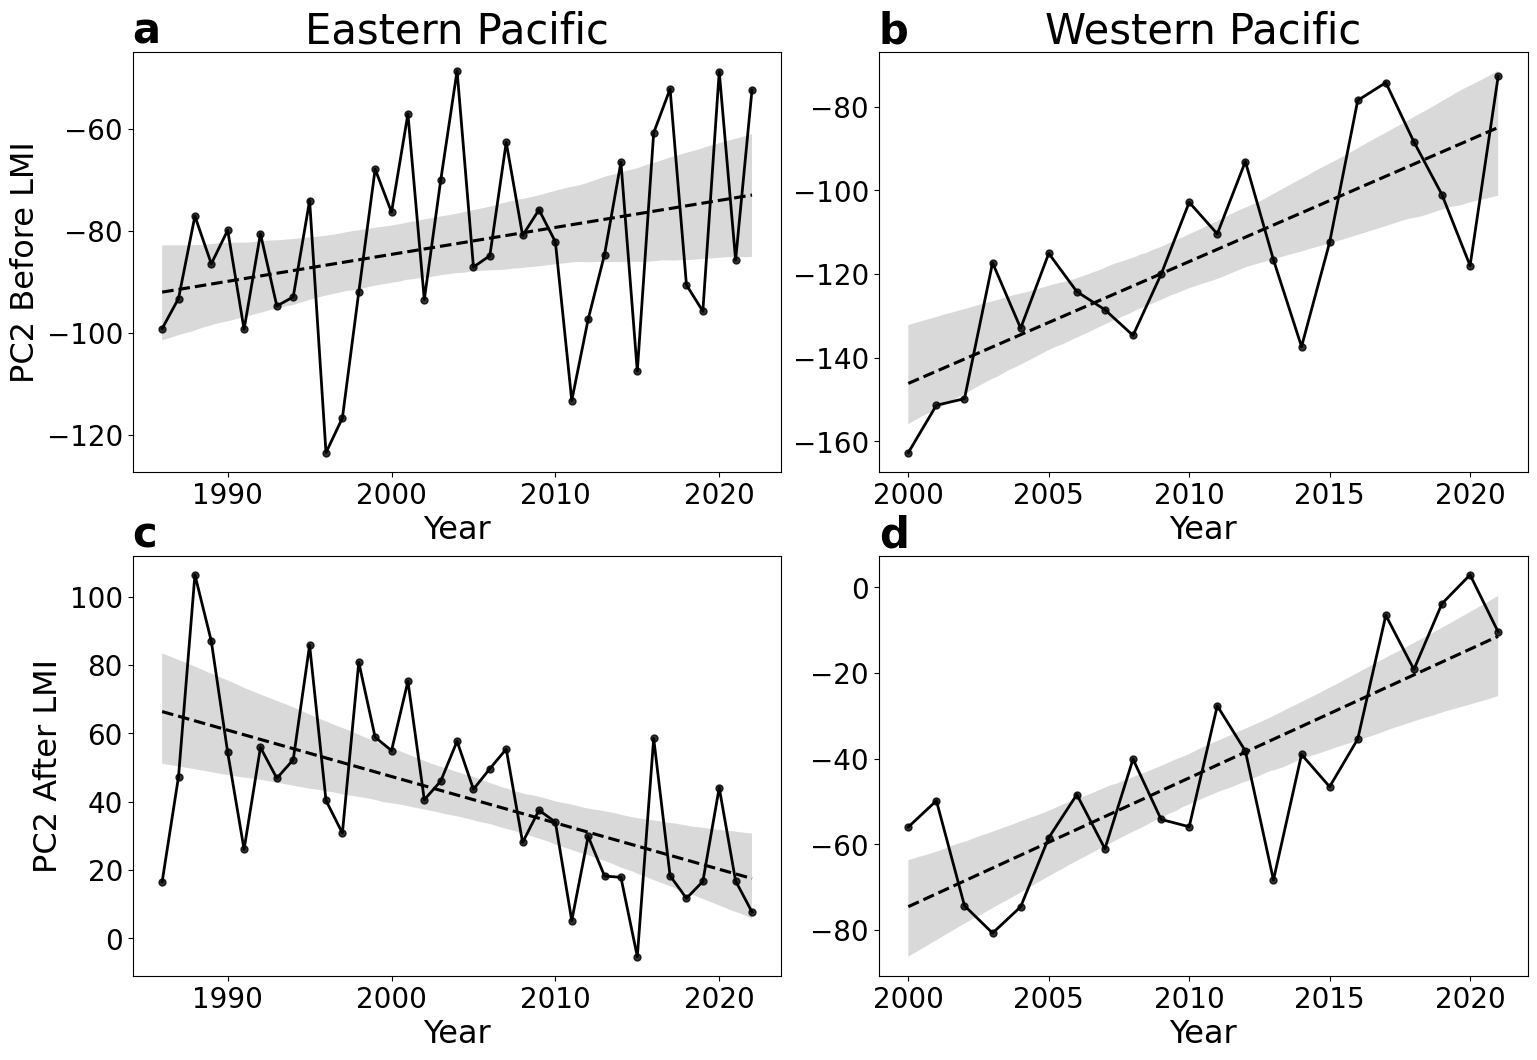

In [51]:
def process_variable_SHIPS(basin, TargetName):       
    ships = pd.read_csv('/workspace/kuilin/ML_TC/data/SHIPS_development_5day/SHIPS_development_%s.csv'%basin)
    ships = ships.replace(9999,np.NaN)
    ships['DATE'] = ships['DATE'].apply(lambda x: str(x).zfill(6))   #fills date to 6 digits with 0
    ships['YEAR'] = ships['DATE'].apply(lambda x: ('19' + str(x)[0:2]) if (str(x)[0]=='8' or str(x)[0]=='9') else ('20' + str(x)[0:2])).astype(int)
    ships['time'] = ships['DATE'].apply(lambda x: ('19' + str(x)) if (str(x)[0]=='8' or str(x)[0]=='9') else ('20' + str(x))) + ships['HOUR'].apply(lambda x: str(x).zfill(2))
    ships['time'] = ships['time'].apply(lambda x: dt.datetime.strptime(x,'%Y%m%d%H'))
    
    if TargetName != 'VMAX':
        ships = ships[['YEAR', 'ID', 'time', 'VMAX', TargetName]]
    else:
        ships = ships[['YEAR', 'ID', 'time', 'VMAX']]
    if TargetName == 'POT':                            # WP082017 has POT=-9954 and CFLX=5682
        ships = ships[(ships['POT']>-9000)]
    if TargetName == 'CFLX':
        ships = ships[(ships['CFLX']<5000)]
    

    ships_ID_unique = sorted(ships['ID'].unique())
    ships_processed = pd.DataFrame(columns=['YEAR', 'ID', 'time', TargetName, 'type', 'duration', 'duration_type'])
    for TC_ID in ships_ID_unique:
        TC_data = ships[ships['ID'] == TC_ID].sort_values(by='time').reset_index(drop=True)
        if len(TC_data) > 0:
            if len(TC_data[TC_data['VMAX'] >= 34]) > 0:
                start_idx = TC_data[TC_data['VMAX'] >= 34].index[0]
                TC_ID_data = TC_data.iloc[start_idx:].reset_index(drop=True)
                TC_duration = (TC_ID_data.iloc[-1]['time'] - TC_ID_data.iloc[0]['time']).total_seconds() / 3600 + 3
                if TC_duration < 100:
                    TC_duration_type = 'short'
                elif TC_duration < 200:
                    TC_duration_type = 'medium'
                else:
                    TC_duration_type = 'long'
                LMI_idx = TC_ID_data['VMAX'].idxmax()
                TC_ID_data['type'] = 'before'
                TC_ID_data.loc[LMI_idx:, 'type'] = 'after'
                TC_ID_data['duration'] = TC_duration
                TC_ID_data['duration_type'] = TC_duration_type
                TC_ID_data = TC_ID_data.dropna().reset_index(drop=True)
                ships_processed = pd.concat([ships_processed, TC_ID_data[['YEAR', 'ID', 'time', TargetName, 'type', 'duration', 'duration_type']]], axis=0, ignore_index=True)

    return ships_processed

def plot_timeseries_SHIPS(df, col, axs, i, j, single_row):
    yearly_mean = df.groupby('YEAR')[col].mean().reset_index()
    years = yearly_mean['YEAR'].values.reshape(-1)
    values = yearly_mean[col].values.reshape(-1)

    if single_row:
        ax = axs[i]
    else:
        ax = axs[i, j]

    sns.regplot(data=yearly_mean, x='YEAR', y=col, ax=ax, scatter=True, ci=95, scatter_kws={'s':25, 'color':'black'}, line_kws={'color':'black', 'linestyle':'--'})    # ci is the confidence interval for regression line, not for individual years
    ax.plot(years, values, linewidth=2, c='black')

    X = sm.add_constant(years)
    model = sm.OLS(values, X).fit()
    slope = model.params[1]
    conf_int = model.conf_int(alpha=0.05)  # alpha=0.05 gives 95% CI
    slope_ci_lower = conf_int[1, 0]  # Lower bound for slope
    slope_ci_upper = conf_int[1, 1]  # Upper bound for slope
    intercept = model.params[0]
    p_value = model.pvalues[1]
    print(f'y = {slope:.2f}x + {intercept:.2f}, p-value = {p_value:.3f}, confidence interval = {slope_ci_lower:.2f} - {slope_ci_upper:.2f}, interval width = {(slope_ci_upper - slope_ci_lower)/2:.2f}')
    
    return years, values

def plot_variable_SHIPS(TargetName, ylabel_before, ylabel_after):
    ships_EPAC = process_variable_SHIPS('EPAC', TargetName)
    ships_WPAC = process_variable_SHIPS('WPAC', TargetName)
    EPAC_before = ships_EPAC[ships_EPAC['type'] == 'before']
    EPAC_after = ships_EPAC[ships_EPAC['type'] == 'after']
    WPAC_before = ships_WPAC[ships_WPAC['type'] == 'before']
    WPAC_after = ships_WPAC[ships_WPAC['type'] == 'after']

    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    plot_timeseries_SHIPS(EPAC_before, TargetName, axs, 0, 0, False)
    axs[0, 0].set_title('Eastern Pacific', fontsize=30)
    axs[0, 0].set_xlabel('Year', fontsize=23)
    axs[0, 0].set_ylabel(ylabel_before, fontsize=23)
    axs[0, 0].tick_params(axis='both', labelsize=20)
    axs[0, 0].text(0, 1.02, 'a', transform=axs[0, 0].transAxes, fontsize=30, fontweight='bold')

    plot_timeseries_SHIPS(WPAC_before, TargetName, axs, 0, 1, False)
    axs[0, 1].set_title('Western Pacific', fontsize=30)
    axs[0, 1].set_xlabel('Year', fontsize=23)
    axs[0, 1].set_ylabel('')
    axs[0, 1].tick_params(axis='both', labelsize=20)
    axs[0, 1].text(0, 1.02, 'b', transform=axs[0, 1].transAxes, fontsize=30, fontweight='bold')

    plot_timeseries_SHIPS(EPAC_after, TargetName, axs, 1, 0, False)
    axs[1, 0].set_xlabel('Year', fontsize=23)
    axs[1, 0].set_ylabel(ylabel_after, fontsize=23)
    axs[1, 0].tick_params(axis='both', labelsize=20)
    axs[1, 0].text(0, 1.02, 'c', transform=axs[1, 0].transAxes, fontsize=30, fontweight='bold')

    plot_timeseries_SHIPS(WPAC_after, TargetName, axs, 1, 1, False)
    axs[1, 1].set_xlabel('Year', fontsize=23)
    axs[1, 1].set_ylabel('')
    axs[1, 1].tick_params(axis='both', labelsize=20)
    axs[1, 1].text(0, 1.02, 'd', transform=axs[1, 1].transAxes, fontsize=30, fontweight='bold')

    plt.subplots_adjust(wspace=0.15, hspace=0.2)

    plt.savefig(f'figures/{TargetName}_trend.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_variable_SHIPS('PC2', 'PC2 Before LMI', 'PC2 After LMI')
